In [ ]:
#!pip install scikeras

In [ ]:
#!pip install keras_tuner

In [ ]:
#!pip install --upgrade tensorflow


In [ ]:
#!pip install --upgrade numpy


# 0. Initial Setup

In [ ]:
# Data Handling and Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning and Deep Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt

# Statistical and Causal Inference Libraries
from scipy.stats import ks_2samp, spearmanr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import tigramite
from knockoffs import Knockoffs
import torch

# Custom Modules
from diagnostics import compute_diagnostics, ScatterCovariance
from functions import deseasonalize

# Utility Libraries
import pickle
import pathlib

from tigramite import data_processing as pp
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite import plotting as tp
from tigramite.models import Models
from tigramite.causal_effects import CausalEffects

In [ ]:
keras.utils.set_random_seed(585)

# 1. EDA and Data Preprocessing

In [ ]:
raw = pd.read_csv('rainbow_six_siege_daily_data.csv')

In [ ]:
raw

DateTime Day of the Week  Followers  Players  Average Players  \
0     12/1/15         Tuesday        NaN     9375              NaN   
1     12/2/15       Wednesday        NaN     9644              NaN   
2     12/3/15        Thursday        NaN     9574              NaN   
3     12/4/15          Friday        NaN     9760              NaN   
4     12/5/15        Saturday        NaN    11185              NaN   
...       ...             ...        ...      ...              ...   
3101  5/28/24         Tuesday  1234810.0    73587      59641.50000   
3102  5/29/24       Wednesday  1234919.0    72059      56994.41667   
3103  5/30/24        Thursday  1235028.0    75042      57615.54167   
3104  5/31/24          Friday  1235145.0    74767      59003.37500   
3105   6/1/24        Saturday  1235269.0    53164      59860.00000   

      Twitch Viewers  Peak viewers  Positive reviews  Negative reviews  \
0              78000         78000                34               -27   
1              43081         43081               384               -40   
2              21731         21731               331               -40   
3              22240         22240               215               -61   
4              20170         20170               145               -52   
...              ...           ...               ...               ...   
3101           63649         77159               212              -184   
3102           85116         85042               198              -193   
3103          109551        110558               243              -142   
3104           81217         94463               251               -90   
3105           84980         96354               178               -62   

         Rating  ...  Top channel  2nd channel  3rd channel  4th channel  \
0     55.737705  ...      10155.0       3511.0       2101.0       1128.0   
1     86.185567  ...       6179.0       3902.0       2537.0       1858.0   
2     87.500000  ...       4705.0       2314.0       1504.0       1052.0   
3     85.159011  ...       3047.0       1815.0       1205.0        859.0   
4     83.446200  ...       4288.0       2093.0       1332.0        976.0   
...         ...  ...          ...          ...          ...          ...   
3101  85.161084  ...       4561.0       2642.0       2010.0       1398.0   
3102  85.150607  ...      11108.0       2167.0       1422.0        999.0   
3103  85.144024  ...      17711.0       2189.0       1643.0       1150.0   
3104  85.140972  ...      10498.0       2247.0       1602.0       1270.0   
3105  85.138929  ...      11008.0       1721.0       1215.0        975.0   

     5th channel  Channels 6-10  Channels 11-25  Channels 26-50  \
0          946.0         3090.0          3047.0          1230.0   
1         1448.0         3878.0          3130.0          1087.0   
2          682.0         1788.0          1903.0           844.0   
3          542.0         1581.0          1531.0           586.0   
4          737.0         1924.0          1495.0           564.0   
...          ...            ...             ...             ...   
3101      1051.0         2708.0          2025.0          1058.0   
3102       749.0         2172.0          1760.0           901.0   
3103       872.0         2194.0          1914.0          1001.0   
3104       995.0         2504.0          1937.0           889.0   
3105       827.0         2554.0          1771.0           754.0   

      Channels 51-100  Channels 101-250  
0               521.0             356.0  
1               534.0             380.0  
2               416.0             323.0  
3               323.0             270.0  
4               339.0             308.0  
...               ...               ...  
3101            693.0             658.0  
3102            699.0             681.0  
3103            655.0             675.0  
3104            687.0             680.0  
3105            613.0             639.0  

[3106 rows x 31 columns]

In [ ]:
raw.columns

Index(['DateTime', 'Day of the Week', 'Followers', 'Players',
       'Average Players', 'Twitch Viewers', 'Peak viewers', 'Positive reviews',
       'Negative reviews', 'Rating', 'Final price', 'Historical low',
       'Original price', 'discount', 'Free Weekend / Free Week',
       'Free Weekend / Free Week(bool)', 'Tournament (INTL)',
       'Average viewers', 'Peak channels', 'Average channels',
       'Viewer ratio (Average view / Average Channel)', 'Top channel',
       '2nd channel', '3rd channel', '4th channel', '5th channel',
       'Channels 6-10', 'Channels 11-25', 'Channels 26-50', 'Channels 51-100',
       'Channels 101-250'],
      dtype='object')

In [ ]:
raw.isnull().sum()

DateTime                                            0
Day of the Week                                     0
Followers                                        1327
Players                                             0
Average Players                                  2488
Twitch Viewers                                      0
Peak viewers                                        0
Positive reviews                                    0
Negative reviews                                    0
Rating                                              0
Final price                                         0
Historical low                                      0
Original price                                      0
discount                                            0
Free Weekend / Free Week                         3008
Free Weekend / Free Week(bool)                      0
Tournament (INTL)                                   0
Average viewers                                     0
Peak channels               

In [ ]:
# turn day of week into dummy variable
day_of_week = pd.get_dummies(raw['Day of the Week']).astype(int)

raw = pd.concat([raw, day_of_week], axis=1)

In [ ]:
raw['is_historical_low'] = np.where(raw['Final price'] == raw['Historical low'], 1, 0)

In [ ]:
predictors = ['Peak viewers', 'Rating', 'Final price', 'is_historical_low']
target = 'Players'

In [ ]:
df = raw[predictors + [target] + ['DateTime']]

In [ ]:
df.loc[:, 'DateTime'] = pd.to_datetime(df['DateTime'], format='%m/%d/%y')

In [ ]:
df = df.set_index('DateTime')

In [ ]:
df

Peak viewers     Rating  Final price  is_historical_low  Players
DateTime                                                                    
2015-12-01         78000  55.737705        59.99                  1     9375
2015-12-02         43081  86.185567        59.99                  1     9644
2015-12-03         21731  87.500000        59.99                  1     9574
2015-12-04         22240  85.159011        59.99                  1     9760
2015-12-05         20170  83.446200        59.99                  1    11185
...                  ...        ...          ...                ...      ...
2024-05-28         77159  85.161084         7.99                  0    73587
2024-05-29         85042  85.150607         7.99                  0    72059
2024-05-30        110558  85.144024         7.99                  0    75042
2024-05-31         94463  85.140972         7.99                  0    74767
2024-06-01         96354  85.138929         7.99                  0    53164

[3106 rows x 5 columns]

In [ ]:
df.columns

Index(['Peak viewers', 'Rating', 'Final price', 'is_historical_low',
       'Players'],
      dtype='object')

In [ ]:
# List of columns to calculate difference
columns_to_diff = [col for col in df.columns if col != 'is_historical_low']

# Calculate the difference
df_diff = df[columns_to_diff].diff()

# If you want to keep the 'is_historical_low' column in the final dataframe
df_diff['is_historical_low'] = df['is_historical_low']

# Display the resulting dataframe
df_diff

Peak viewers     Rating  Final price  Players  is_historical_low
DateTime                                                                    
2015-12-01           NaN        NaN          NaN      NaN                  1
2015-12-02      -34919.0  30.447862          0.0    269.0                  1
2015-12-03      -21350.0   1.314433          0.0    -70.0                  1
2015-12-04         509.0  -2.340989          0.0    186.0                  1
2015-12-05       -2070.0  -1.712810          0.0   1425.0                  1
...                  ...        ...          ...      ...                ...
2024-05-28       52549.0  -0.009727          0.0  -8210.0                  0
2024-05-29        7883.0  -0.010477          0.0  -1528.0                  0
2024-05-30       25516.0  -0.006583          0.0   2983.0                  0
2024-05-31      -16095.0  -0.003052          0.0   -275.0                  0
2024-06-01        1891.0  -0.002043          0.0 -21603.0                  0

[3106 rows x 5 columns]

In [ ]:
df_diff = df_diff.dropna()

In [ ]:
df_diff

Peak viewers     Rating  Final price  Players  is_historical_low
DateTime                                                                    
2015-12-02      -34919.0  30.447862          0.0    269.0                  1
2015-12-03      -21350.0   1.314433          0.0    -70.0                  1
2015-12-04         509.0  -2.340989          0.0    186.0                  1
2015-12-05       -2070.0  -1.712810          0.0   1425.0                  1
2015-12-06        4123.0  -0.505024          0.0   -835.0                  1
...                  ...        ...          ...      ...                ...
2024-05-28       52549.0  -0.009727          0.0  -8210.0                  0
2024-05-29        7883.0  -0.010477          0.0  -1528.0                  0
2024-05-30       25516.0  -0.006583          0.0   2983.0                  0
2024-05-31      -16095.0  -0.003052          0.0   -275.0                  0
2024-06-01        1891.0  -0.002043          0.0 -21603.0                  0

[3105 rows x 5 columns]

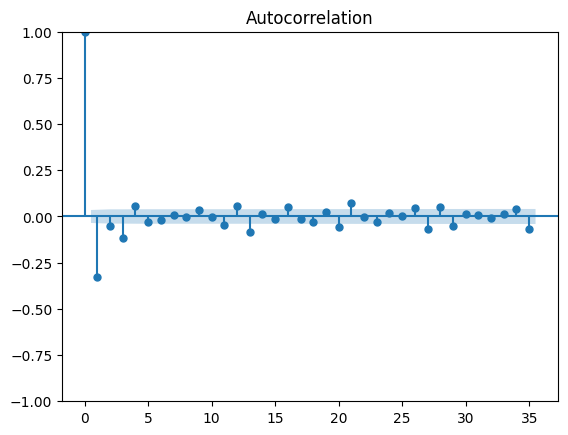

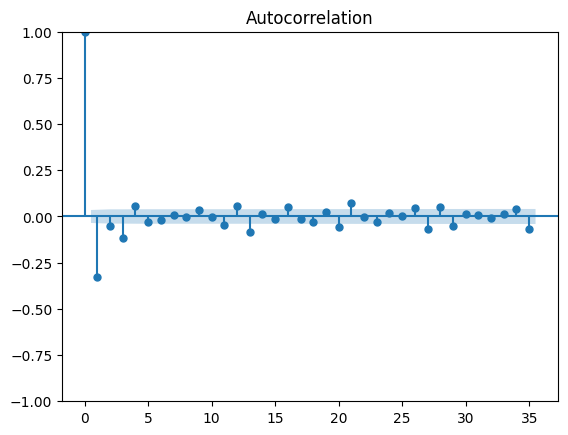

In [ ]:
plot_acf(df_diff['Peak viewers'])

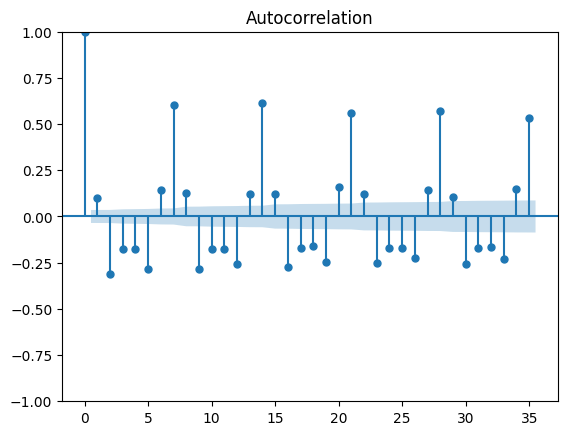

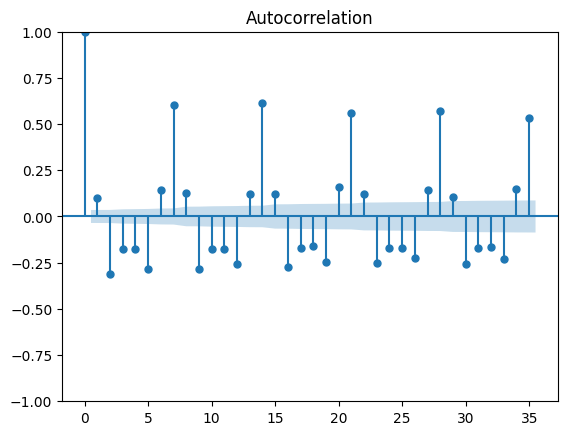

In [ ]:
plot_acf(df_diff['Players'])

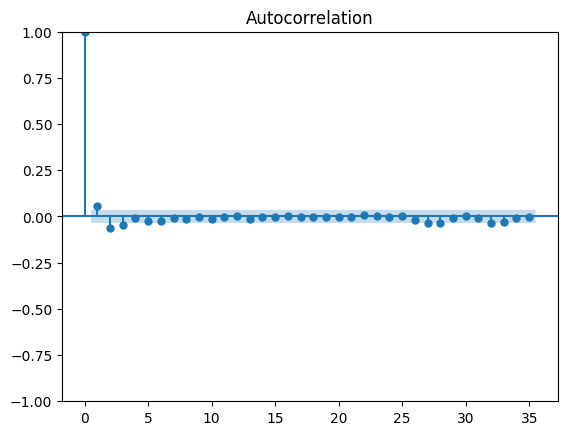

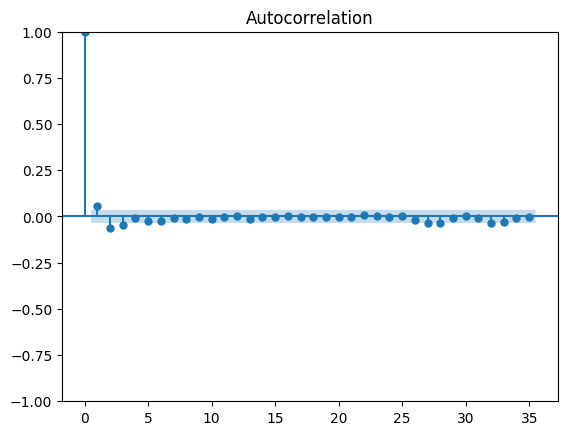

In [ ]:
plot_acf(df_diff['Rating'])

In [ ]:
Players = df_diff[['Players']]

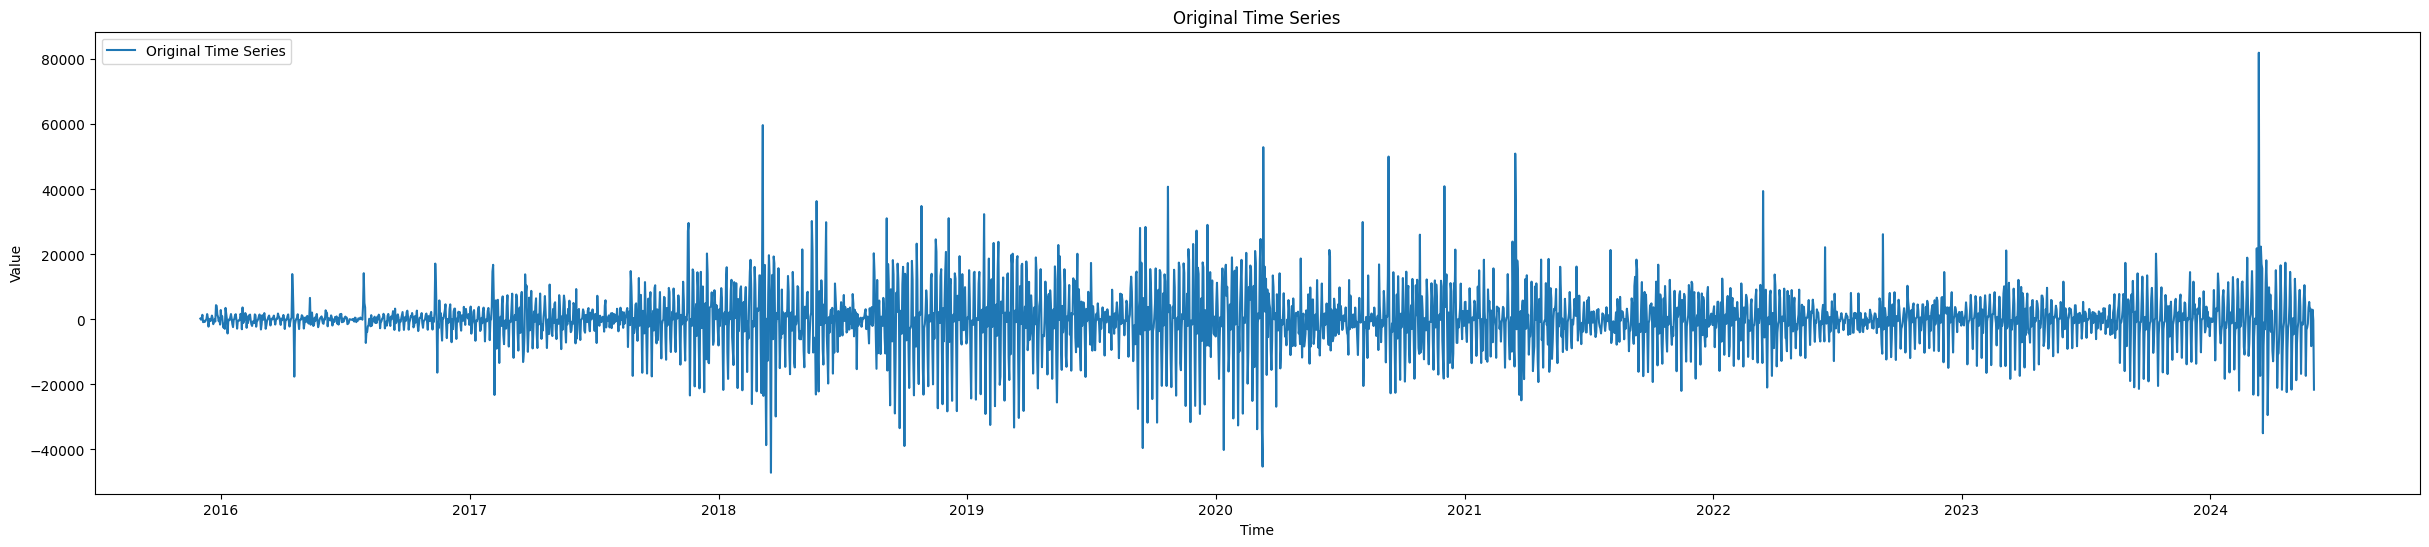

In [ ]:
# Plot the original time series
plt.figure(figsize=(30, 6))
plt.plot(Players, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

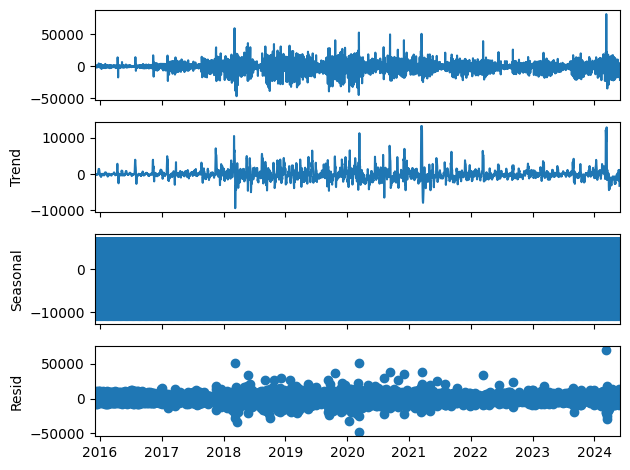

In [ ]:
# Decompose the time series
result = seasonal_decompose(Players, model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [ ]:
# Deseasonalize the time series
deseasonalized_player = Players['Players'] - result.seasonal

In [ ]:
deseasonalized_player

DateTime
2015-12-02    -1215.014110
2015-12-03      768.916179
2015-12-04    -7148.278714
2015-12-05    -4858.722591
2015-12-06     1449.779182
                  ...     
2024-05-28    -8107.901888
2024-05-29    -3012.014110
2024-05-30     3821.916179
2024-05-31    -7609.278714
2024-06-01   -27886.722591
Length: 3105, dtype: float64

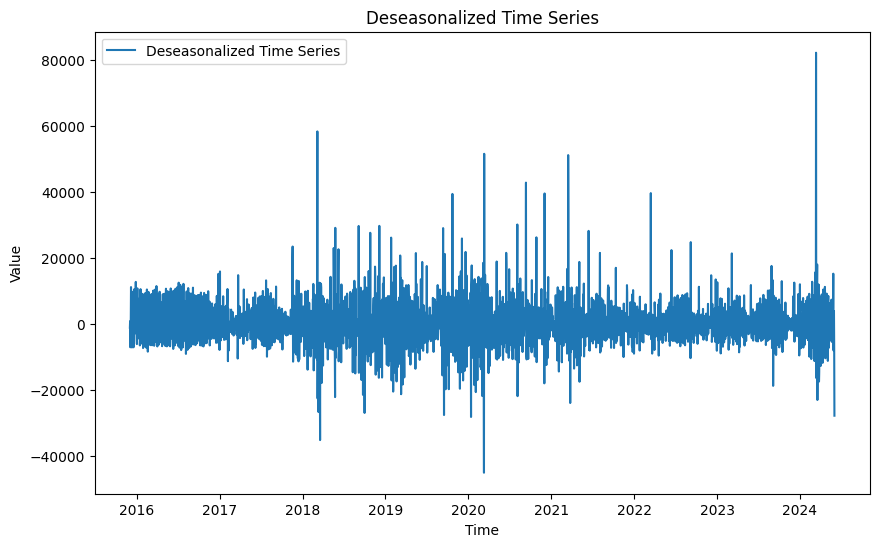

In [ ]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_player, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
df_diff = pd.concat([df_diff, deseasonalized_player], axis=1)

In [ ]:
df_diff

Peak viewers     Rating  Final price  Players  is_historical_low  \
DateTime                                                                       
2015-12-02      -34919.0  30.447862          0.0    269.0                  1   
2015-12-03      -21350.0   1.314433          0.0    -70.0                  1   
2015-12-04         509.0  -2.340989          0.0    186.0                  1   
2015-12-05       -2070.0  -1.712810          0.0   1425.0                  1   
2015-12-06        4123.0  -0.505024          0.0   -835.0                  1   
...                  ...        ...          ...      ...                ...   
2024-05-28       52549.0  -0.009727          0.0  -8210.0                  0   
2024-05-29        7883.0  -0.010477          0.0  -1528.0                  0   
2024-05-30       25516.0  -0.006583          0.0   2983.0                  0   
2024-05-31      -16095.0  -0.003052          0.0   -275.0                  0   
2024-06-01        1891.0  -0.002043          0.0 -21603.0                  0   

                       0  
DateTime                  
2015-12-02  -1215.014110  
2015-12-03    768.916179  
2015-12-04  -7148.278714  
2015-12-05  -4858.722591  
2015-12-06   1449.779182  
...                  ...  
2024-05-28  -8107.901888  
2024-05-29  -3012.014110  
2024-05-30   3821.916179  
2024-05-31  -7609.278714  
2024-06-01 -27886.722591  

[3105 rows x 6 columns]

In [ ]:
df_diff.columns = ['Peak viewers', 'Rating', 'Final price',	'Players', 'is_historical_low', 'Deseasonalized_players']

In [ ]:
df_diff = df_diff.drop('Players', axis = 1)

In [ ]:
df_diff

Peak viewers     Rating  Final price  is_historical_low  \
DateTime                                                              
2015-12-02      -34919.0  30.447862          0.0                  1   
2015-12-03      -21350.0   1.314433          0.0                  1   
2015-12-04         509.0  -2.340989          0.0                  1   
2015-12-05       -2070.0  -1.712810          0.0                  1   
2015-12-06        4123.0  -0.505024          0.0                  1   
...                  ...        ...          ...                ...   
2024-05-28       52549.0  -0.009727          0.0                  0   
2024-05-29        7883.0  -0.010477          0.0                  0   
2024-05-30       25516.0  -0.006583          0.0                  0   
2024-05-31      -16095.0  -0.003052          0.0                  0   
2024-06-01        1891.0  -0.002043          0.0                  0   

            Deseasonalized_players  
DateTime                            
2015-12-02            -1215.014110  
2015-12-03              768.916179  
2015-12-04            -7148.278714  
2015-12-05            -4858.722591  
2015-12-06             1449.779182  
...                            ...  
2024-05-28            -8107.901888  
2024-05-29            -3012.014110  
2024-05-30             3821.916179  
2024-05-31            -7609.278714  
2024-06-01           -27886.722591  

[3105 rows x 5 columns]

In [ ]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
check_stationarity(df_diff['Deseasonalized_players'])

ADF Statistic: -10.72935112128538
p-value: 3.0076208486498965e-19
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


<Axes: >

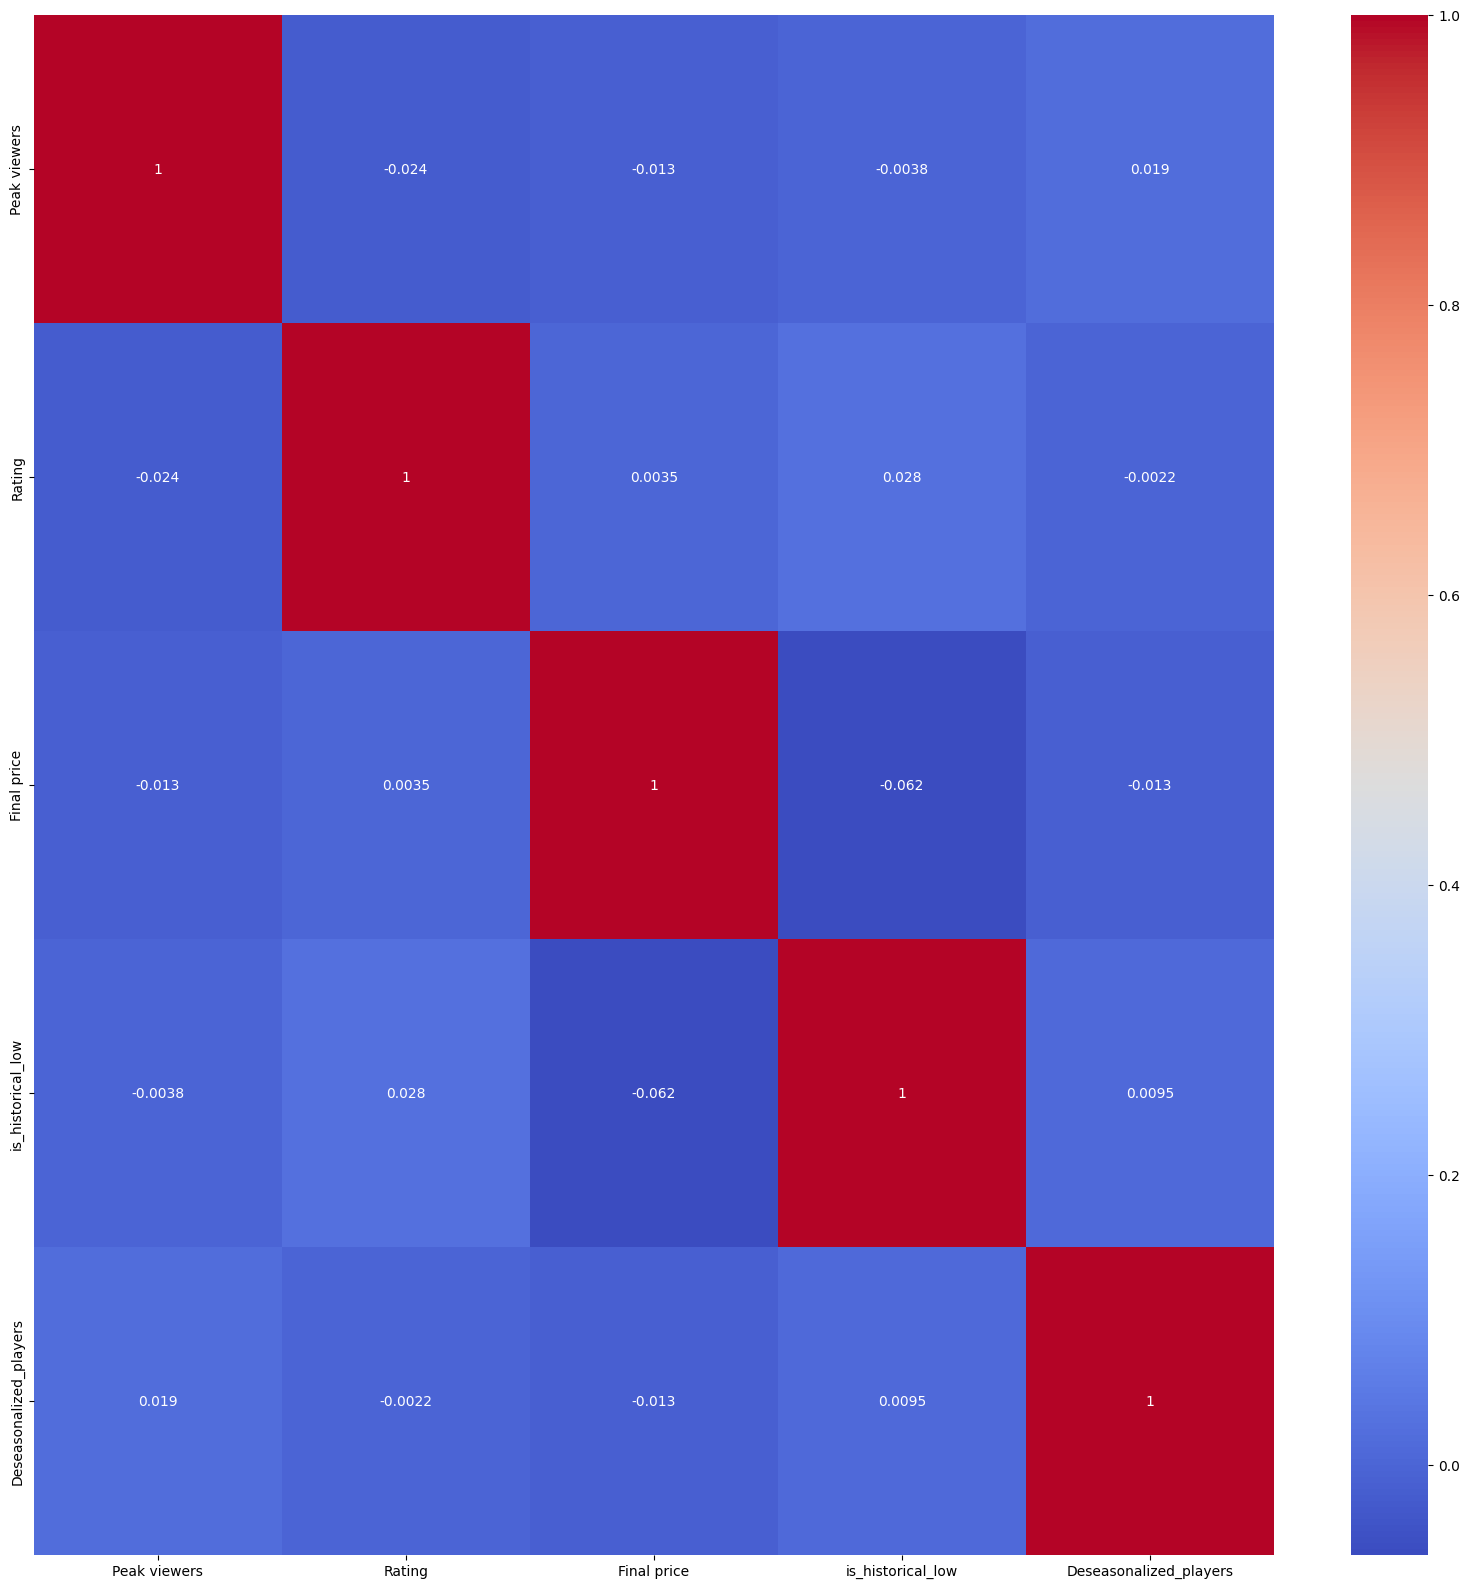

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_diff.corr(),
            annot = True,
            cmap = 'coolwarm')

In [ ]:
for i in range(1,15):
    df_diff['Peak viewers_shift_' + str(i)] = df_diff['Peak viewers'].shift(i)
for i in range(1,8):
    df_diff['Rating_shift_' + str(i)] = df_diff['Rating'].shift(i)
for i in range(1,8):
    df_diff['Final price_shift_' + str(i)] = df_diff['Final price'].shift(i)
for i in range(1,8):
    df_diff['is_historical_low_shift_' + str(i)] = df_diff['is_historical_low'].shift(i)

In [ ]:
df_diff = df_diff.dropna()

<Axes: >

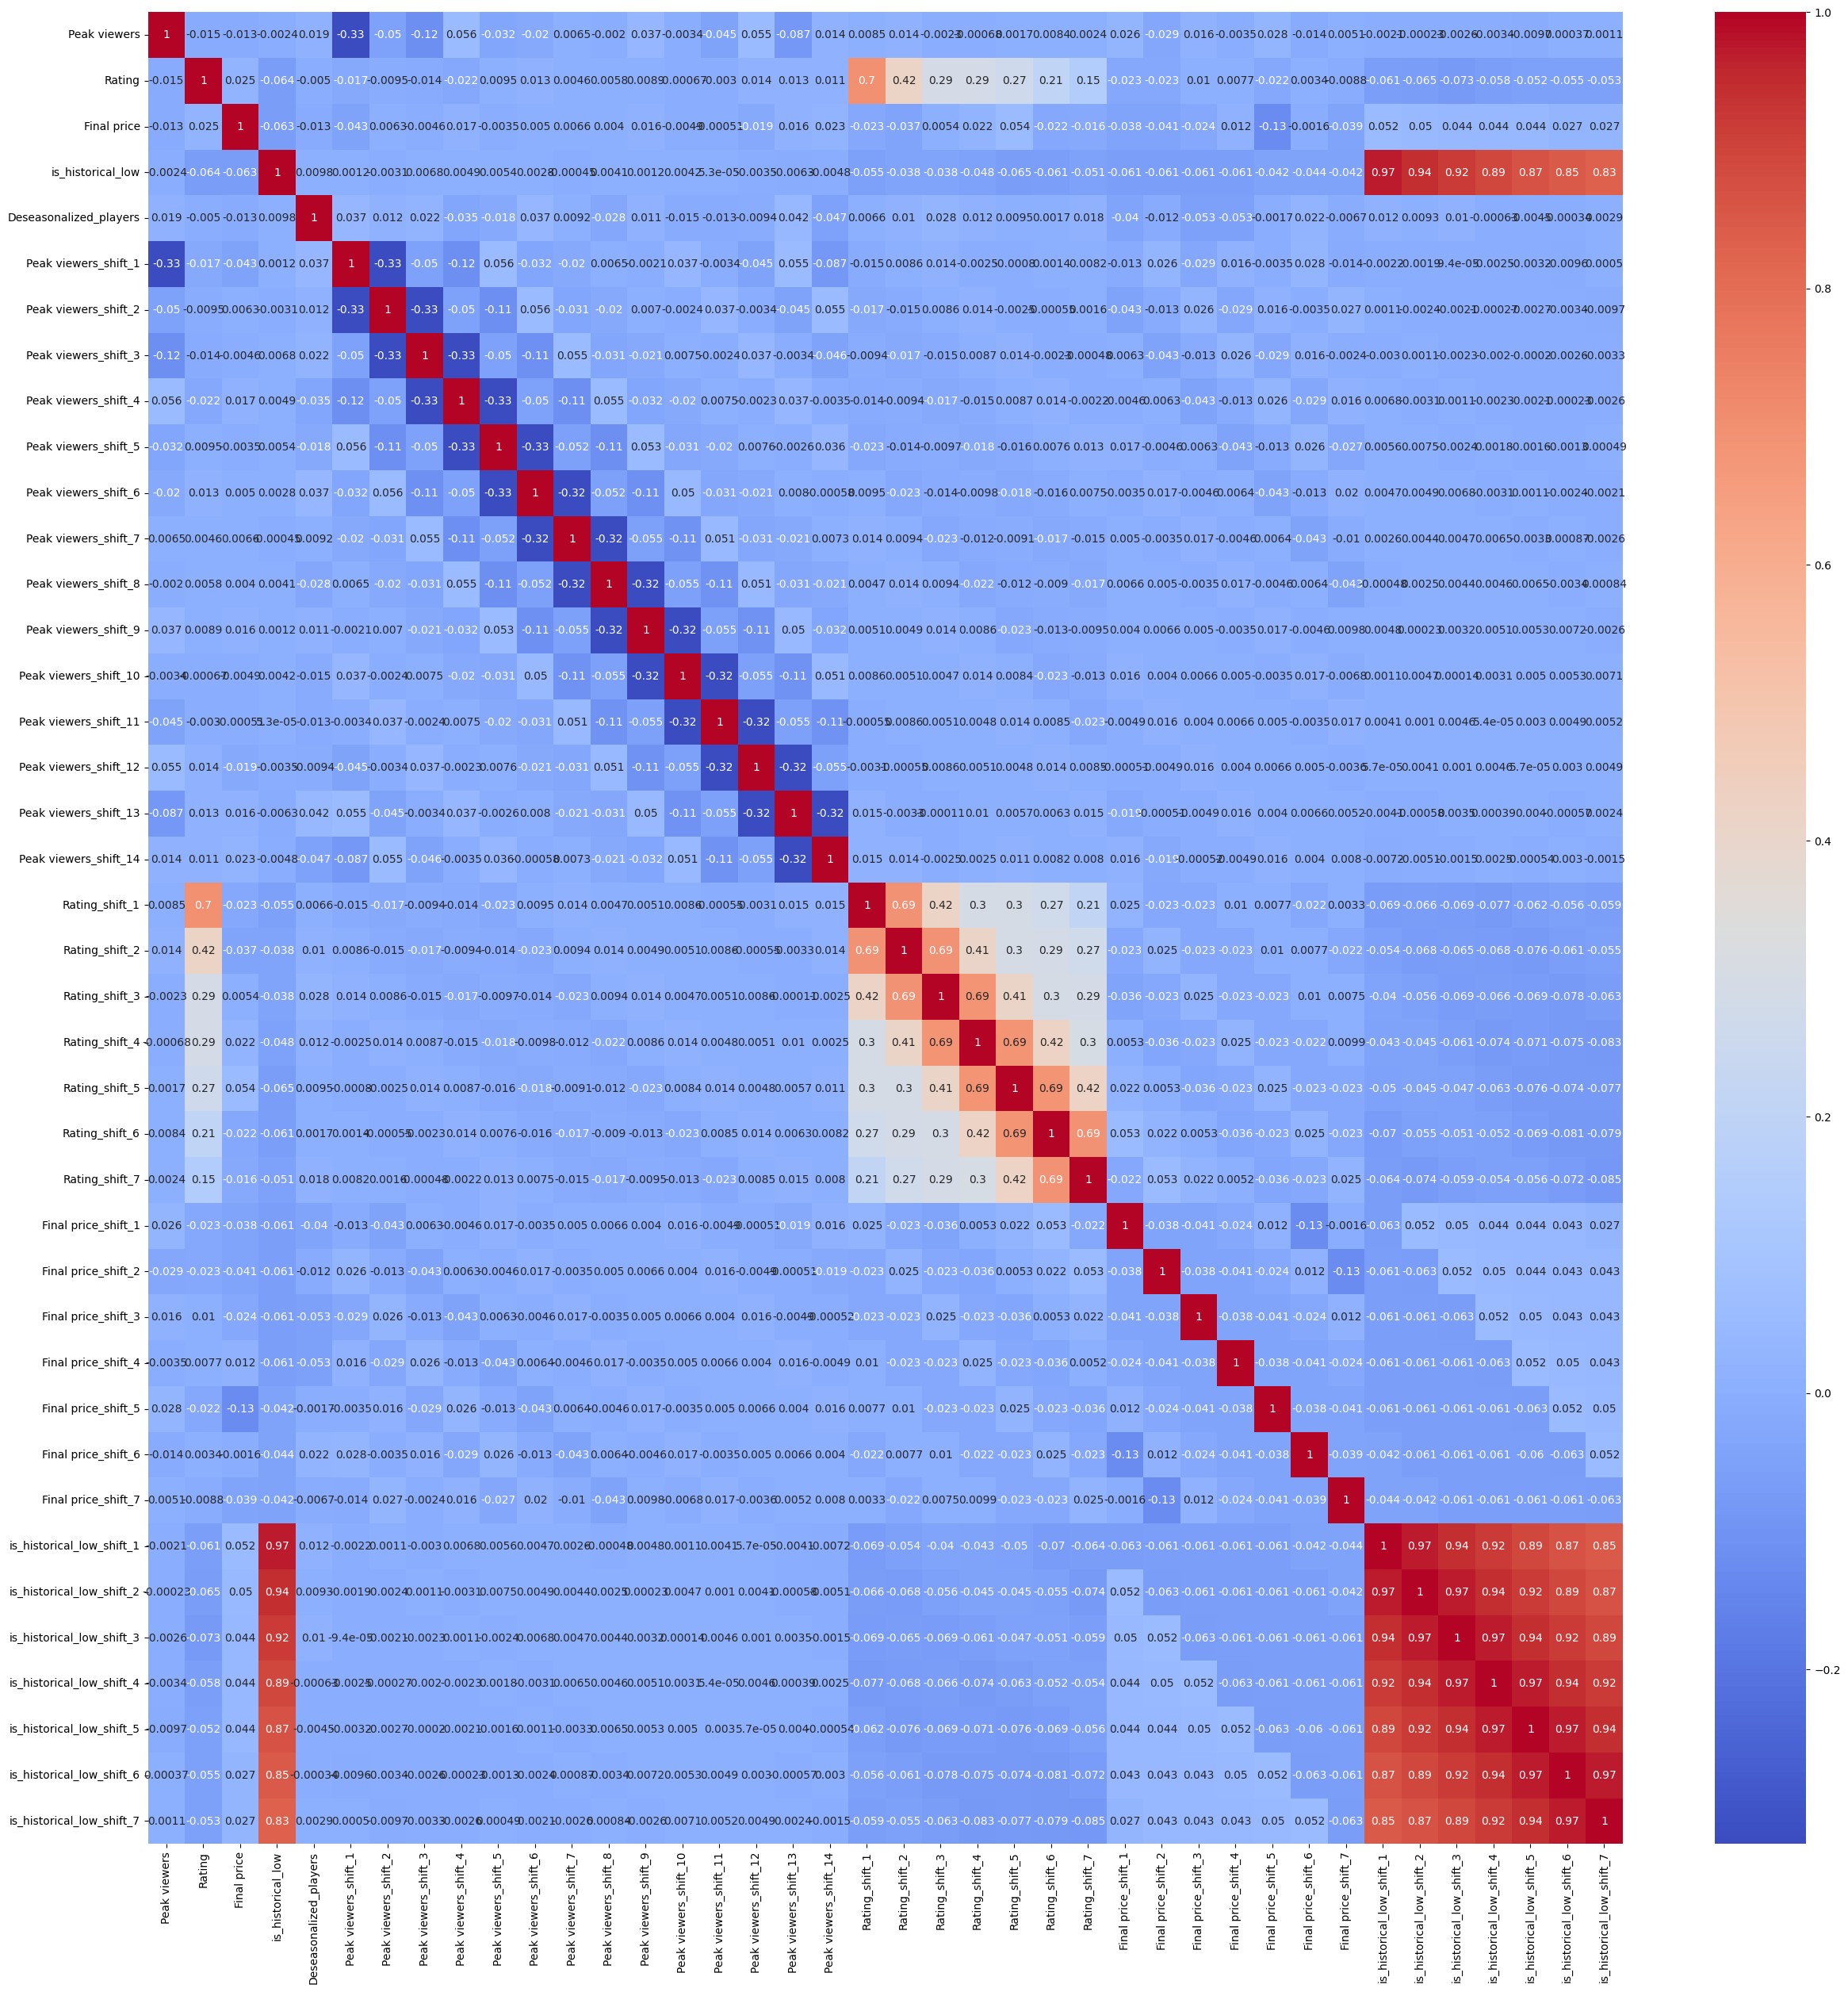

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_diff.corr(),
            annot = True,
            cmap = 'coolwarm')

In [ ]:
df_diff.columns

Index(['Peak viewers', 'Rating', 'Final price', 'is_historical_low',
       'Deseasonalized_players', 'Peak viewers_shift_1',
       'Peak viewers_shift_2', 'Peak viewers_shift_3', 'Peak viewers_shift_4',
       'Peak viewers_shift_5', 'Peak viewers_shift_6', 'Peak viewers_shift_7',
       'Peak viewers_shift_8', 'Peak viewers_shift_9', 'Peak viewers_shift_10',
       'Peak viewers_shift_11', 'Peak viewers_shift_12',
       'Peak viewers_shift_13', 'Peak viewers_shift_14', 'Rating_shift_1',
       'Rating_shift_2', 'Rating_shift_3', 'Rating_shift_4', 'Rating_shift_5',
       'Rating_shift_6', 'Rating_shift_7', 'Final price_shift_1',
       'Final price_shift_2', 'Final price_shift_3', 'Final price_shift_4',
       'Final price_shift_5', 'Final price_shift_6', 'Final price_shift_7',
       'is_historical_low_shift_1', 'is_historical_low_shift_2',
       'is_historical_low_shift_3', 'is_historical_low_shift_4',
       'is_historical_low_shift_5', 'is_historical_low_shift_6',
       'is_h

# 2. Linear Regression

In [ ]:
df_linreg = raw[['Players', 'Peak viewers', 'Rating', 'Final price', 'Free Weekend / Free Week(bool)', 'Tournament (INTL)', 'is_historical_low', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday']]

In [ ]:
# stationarize
df_linreg['Players'] = df_linreg['Players'].diff().dropna()
df_linreg['Peak viewers'] = df_linreg['Peak viewers'].diff().dropna()
df_linreg['Rating'] = df_linreg['Rating'].diff().dropna()
df_linreg['Final price'] = df_linreg['Final price'].diff().dropna()

In [ ]:
df_linreg = df_linreg.iloc[1:]

In [ ]:
df_linreg

Players  Peak viewers     Rating  Final price  \
1       269.0      -34919.0  30.447862          0.0   
2       -70.0      -21350.0   1.314433          0.0   
3       186.0         509.0  -2.340989          0.0   
4      1425.0       -2070.0  -1.712810          0.0   
5      -835.0        4123.0  -0.505024          0.0   
...       ...           ...        ...          ...   
3101  -8210.0       52549.0  -0.009727          0.0   
3102  -1528.0        7883.0  -0.010477          0.0   
3103   2983.0       25516.0  -0.006583          0.0   
3104   -275.0      -16095.0  -0.003052          0.0   
3105 -21603.0        1891.0  -0.002043          0.0   

      Free Weekend / Free Week(bool)  Tournament (INTL)  is_historical_low  \
1                                  0                  0                  1   
2                                  0                  0                  1   
3                                  0                  0                  1   
4                                  0                  0                  1   
5                                  0                  0                  1   
...                              ...                ...                ...   
3101                               0                  0                  0   
3102                               0                  0                  0   
3103                               0                  0                  0   
3104                               0                  0                  0   
3105                               0                  0                  0   

      Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  
1          0       0         0       0         0        0          1  
2          0       0         0       0         1        0          0  
3          1       0         0       0         0        0          0  
4          0       0         1       0         0        0          0  
5          0       0         0       1         0        0          0  
...      ...     ...       ...     ...       ...      ...        ...  
3101       0       0         0       0         0        1          0  
3102       0       0         0       0         0        0          1  
3103       0       0         0       0         1        0          0  
3104       1       0         0       0         0        0          0  
3105       0       0         1       0         0        0          0  

[3105 rows x 14 columns]

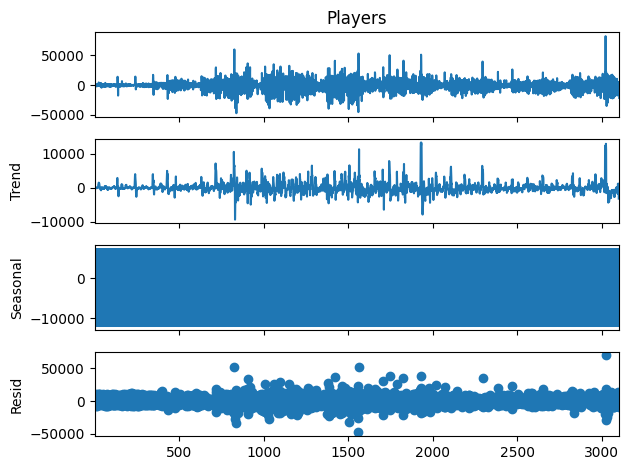

In [ ]:
# Decompose the time series
result = seasonal_decompose(df_linreg['Players'], model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [ ]:
df_linreg['Deseasonalized_players'] = df_linreg['Players'] - result.seasonal

In [ ]:
df_granger = df_linreg

In [ ]:
df_linreg

Players  Peak viewers     Rating  Final price  \
1       269.0      -34919.0  30.447862          0.0   
2       -70.0      -21350.0   1.314433          0.0   
3       186.0         509.0  -2.340989          0.0   
4      1425.0       -2070.0  -1.712810          0.0   
5      -835.0        4123.0  -0.505024          0.0   
...       ...           ...        ...          ...   
3101  -8210.0       52549.0  -0.009727          0.0   
3102  -1528.0        7883.0  -0.010477          0.0   
3103   2983.0       25516.0  -0.006583          0.0   
3104   -275.0      -16095.0  -0.003052          0.0   
3105 -21603.0        1891.0  -0.002043          0.0   

      Free Weekend / Free Week(bool)  Tournament (INTL)  is_historical_low  \
1                                  0                  0                  1   
2                                  0                  0                  1   
3                                  0                  0                  1   
4                                  0                  0                  1   
5                                  0                  0                  1   
...                              ...                ...                ...   
3101                               0                  0                  0   
3102                               0                  0                  0   
3103                               0                  0                  0   
3104                               0                  0                  0   
3105                               0                  0                  0   

      Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
1          0       0         0       0         0        0          1   
2          0       0         0       0         1        0          0   
3          1       0         0       0         0        0          0   
4          0       0         1       0         0        0          0   
5          0       0         0       1         0        0          0   
...      ...     ...       ...     ...       ...      ...        ...   
3101       0       0         0       0         0        1          0   
3102       0       0         0       0         0        0          1   
3103       0       0         0       0         1        0          0   
3104       1       0         0       0         0        0          0   
3105       0       0         1       0         0        0          0   

      Deseasonalized_players  
1               -1215.014110  
2                 768.916179  
3               -7148.278714  
4               -4858.722591  
5                1449.779182  
...                      ...  
3101            -8107.901888  
3102            -3012.014110  
3103             3821.916179  
3104            -7609.278714  
3105           -27886.722591  

[3105 rows x 15 columns]

In [ ]:
for i in range(1,15):
    df_linreg['Peak viewers_shift_' + str(i)] = df_linreg['Peak viewers'].shift(i)
for i in range(1,8):
    df_linreg['Rating_shift_' + str(i)] = df_linreg['Rating'].shift(i)
for i in range(1,8):
    df_linreg['Final price_shift_' + str(i)] = df_linreg['Final price'].shift(i)
for i in range(1,8):
    df_linreg['is_historical_low_shift_' + str(i)] = df_linreg['is_historical_low'].shift(i)

In [ ]:
df_linreg = df_linreg.dropna()

In [ ]:
df_linreg = pd.concat([df_linreg, raw['Day of the Week']], axis = 1)
df_linreg = df_linreg.dropna()
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
df_linreg['Day of the Week'] = df_linreg['Day of the Week'].map(day_mapping)

In [ ]:
# model 1
x_1 = df_linreg[['Peak viewers', 'Peak viewers_shift_1', 'Peak viewers_shift_2', 'Peak viewers_shift_3',
       'Peak viewers_shift_4', 'Peak viewers_shift_5', 'Peak viewers_shift_6',
       'Peak viewers_shift_7', 'Peak viewers_shift_8', 'Peak viewers_shift_9',
       'Peak viewers_shift_10', 'Peak viewers_shift_11',
       'Peak viewers_shift_12', 'Peak viewers_shift_13',
       'Peak viewers_shift_14']]

y = df_linreg['Deseasonalized_players']

x_1 = sm.add_constant(x_1)

model_1 = sm.OLS(y, x_1)
print(model_1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.012
Model:                                OLS   Adj. R-squared:                  0.007
Method:                     Least Squares   F-statistic:                     2.458
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):            0.00138
Time:                            21:32:49   Log-Likelihood:                -31664.
No. Observations:                    3091   AIC:                         6.336e+04
Df Residuals:                        3075   BIC:                         6.346e+04
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [ ]:
# model 2  with only Peak viewers and its lags
x_2 = df_linreg[['Rating', 'Rating_shift_1', 'Rating_shift_2',
       'Rating_shift_3', 'Rating_shift_4', 'Rating_shift_5', 'Rating_shift_6',
       'Rating_shift_7']]
y = df_linreg['Deseasonalized_players']

x_2 = sm.add_constant(x_2)

model_2 = sm.OLS(y, x_2)
print(model_2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.002
Model:                                OLS   Adj. R-squared:                 -0.001
Method:                     Least Squares   F-statistic:                    0.6917
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):              0.699
Time:                            21:32:49   Log-Likelihood:                -31679.
No. Observations:                    3091   AIC:                         6.338e+04
Df Residuals:                        3082   BIC:                         6.343e+04
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
cons

In [ ]:
# model 3
x_3 = df_linreg[['Final price', 'Final price_shift_1', 'Final price_shift_2',
       'Final price_shift_3', 'Final price_shift_4', 'Final price_shift_5',
       'Final price_shift_6', 'Final price_shift_7']]

y = df_linreg['Deseasonalized_players']

x_3 = sm.add_constant(x_3)

model_3 = sm.OLS(y, x_3)
print(model_3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                  0.006
Method:                     Least Squares   F-statistic:                     3.337
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):           0.000826
Time:                            21:32:49   Log-Likelihood:                -31669.
No. Observations:                    3091   AIC:                         6.336e+04
Df Residuals:                        3082   BIC:                         6.341e+04
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [ ]:
# model 4
x_4 = df_linreg[['Peak viewers', 'Rating', 'Final price',
       'Free Weekend / Free Week(bool)', 'Tournament (INTL)',
       'is_historical_low', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday',
       'Peak viewers_shift_1', 'Peak viewers_shift_2', 'Peak viewers_shift_3',
       'Peak viewers_shift_4', 'Peak viewers_shift_5', 'Peak viewers_shift_6',
       'Peak viewers_shift_7', 'Peak viewers_shift_8', 'Peak viewers_shift_9',
       'Peak viewers_shift_10', 'Peak viewers_shift_11',
       'Peak viewers_shift_12', 'Peak viewers_shift_13',
       'Peak viewers_shift_14', 'Rating_shift_1', 'Rating_shift_2',
       'Rating_shift_3', 'Rating_shift_4', 'Rating_shift_5', 'Rating_shift_6',
       'Rating_shift_7', 'Final price_shift_1', 'Final price_shift_2',
       'Final price_shift_3', 'Final price_shift_4', 'Final price_shift_5',
       'Final price_shift_6', 'Final price_shift_7']]

y = df_linreg['Deseasonalized_players']

x_4 = sm.add_constant(x_4)

model_4 = sm.OLS(y, x_4)
print(model_4.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.026
Model:                                OLS   Adj. R-squared:                  0.013
Method:                     Least Squares   F-statistic:                     2.052
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):           0.000117
Time:                            21:32:49   Log-Likelihood:                -31641.
No. Observations:                    3091   AIC:                         6.336e+04
Df Residuals:                        3050   BIC:                         6.361e+04
Df Model:                              40                                         
Covariance Type:                nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
# model 5
x_5 = df_linreg[['Peak viewers', 'Rating', 'Final price',
       'Free Weekend / Free Week(bool)', 'Tournament (INTL)',
       'is_historical_low', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday']]

y = df_linreg['Deseasonalized_players']

x_5 = sm.add_constant(x_5)

model_5 = sm.OLS(y, x_5)
print(model_5.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                  0.005
Method:                     Least Squares   F-statistic:                     2.241
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):            0.00819
Time:                            21:32:49   Log-Likelihood:                -31669.
No. Observations:                    3091   AIC:                         6.336e+04
Df Residuals:                        3078   BIC:                         6.344e+04
Df Model:                              12                                         
Covariance Type:                nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
# model 6
x_6 = df_linreg[['Peak viewers', 'Rating', 'Final price', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
          'Free Weekend / Free Week(bool)', 'Tournament (INTL)', 'is_historical_low_shift_5',
          'Peak viewers_shift_1', 'Peak viewers_shift_6', 'Peak viewers_shift_13',
          'Final price_shift_3', 'Final price_shift_4']]

y = df_linreg['Deseasonalized_players']

x_6 = sm.add_constant(x_6)

model_6 = sm.OLS(y, x_6)
print(model_6.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.018
Model:                                OLS   Adj. R-squared:                  0.012
Method:                     Least Squares   F-statistic:                     3.222
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):           8.47e-06
Time:                            21:32:49   Log-Likelihood:                -31655.
No. Observations:                    3091   AIC:                         6.335e+04
Df Residuals:                        3073   BIC:                         6.345e+04
Df Model:                              17                                         
Covariance Type:                nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

# 3. Granger Casuality Test

In [ ]:
from statsmodels.tsa.api import VAR

## Granger-causality test
model = VAR(df_granger[['Peak viewers', 'Deseasonalized_players']])
lag_order = model.select_order(maxlags=15)
print('AIC selected lag order:', lag_order.aic)

AIC selected lag order: 15


In [ ]:
gc_res1 = grangercausalitytests(df_granger[['Deseasonalized_players', 'Peak viewers']], maxlag=lag_order.aic)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1873  , p=0.0408  , df_denom=3101, df_num=1
ssr based chi2 test:   chi2=4.1914  , p=0.0406  , df=1
likelihood ratio test: chi2=4.1885  , p=0.0407  , df=1
parameter F test:         F=4.1873  , p=0.0408  , df_denom=3101, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1840  , p=0.0021  , df_denom=3098, df_num=2
ssr based chi2 test:   chi2=12.3879 , p=0.0020  , df=2
likelihood ratio test: chi2=12.3633 , p=0.0021  , df=2
parameter F test:         F=6.1840  , p=0.0021  , df_denom=3098, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1875  , p=0.0001  , df_denom=3095, df_num=3
ssr based chi2 test:   chi2=21.6114 , p=0.0001  , df=3
likelihood ratio test: chi2=21.5364 , p=0.0001  , df=3
parameter F test:         F=7.1875  , p=0.0001  , df_denom=3095, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.4333  , p=0.

# 4. Causal Discovery using Model Invariance (CDMI)

In [ ]:
X = df_diff[['Peak viewers',  'Final price', 'is_historical_low',
                       'Peak viewers_shift_1',
                       'Peak viewers_shift_2', 'Peak viewers_shift_3',
                       'Peak viewers_shift_4', 'Peak viewers_shift_5',
                       'Peak viewers_shift_6', 'Peak viewers_shift_7',
                       'Peak viewers_shift_8', 'Peak viewers_shift_9',
                       'Peak viewers_shift_10', 'Peak viewers_shift_11',
                       'Peak viewers_shift_12', 'Peak viewers_shift_13',
                       'Peak viewers_shift_14',
                       'Rating_shift_1', 'Rating_shift_7',
                       'Final price_shift_1', 'Final price_shift_2',
                       'Final price_shift_3', 'Final price_shift_4',
                       'Final price_shift_5', 'Final price_shift_6', 'Final price_shift_7',
                       'is_historical_low_shift_1', 'is_historical_low_shift_2',
                       'is_historical_low_shift_3', 'is_historical_low_shift_4',
                       'is_historical_low_shift_5', 'is_historical_low_shift_6',
                       'is_historical_low_shift_7']]

X = X.drop(X.index[-1])
# Cannot solve for knockoffs with 'Rating', thus chose to discard it.

In [ ]:
#X = deseasonalized_df.drop(['Players_deseasonalized', 'Players'], axis = 1)
#X = X.drop(columns=[col for col in X.columns if 'Final price' in col])
y = df_diff['Deseasonalized_players']

In [ ]:
# Initialize TimeSeriesSplit with 4 splits
tscv = TimeSeriesSplit(n_splits=4)

# Iterate through the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [ ]:
# Start Artificial Neural Network
model = keras.Sequential()

# Adding the input layer and the first hidden layer
model.add(keras.layers.Dense(units=64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the second hidden layer
model.add(keras.layers.Dense(units=32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the third hidden layer
model.add(keras.layers.Dense(units=32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the output layer
model.add(keras.layers.Dense(units=1, activation='linear'))

# Learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Specify optimizer with learning rate schedule
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile NN
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks_list = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10)
]

In [ ]:
history = model.fit(X_train, y_train, epochs= 100, batch_size = 50, validation_data = (X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
50/50 [==============================] - 1s 6ms/step - loss: 133766880.0000 - mae: 7605.8643 - val_loss: 56713824.0000 - val_mae: 4976.6460
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 80812272.0000 - mae: 6175.3374 - val_loss: 44159752.0000 - val_mae: 4323.4331
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 67530688.0000 - mae: 5701.2783 - val_loss: 41268728.0000 - val_mae: 4098.4204
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 62072016.0000 - mae: 5500.4062 - val_loss: 39392972.0000 - val_mae: 3986.1626
Epoch 5/100
50/50 [==============================] - 0s 3ms/step - loss: 58359972.0000 - mae: 5319.9961 - val_loss: 39185476.0000 - val_mae: 3979.4810
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 53837564.0000 - mae: 5121.2612 - val_loss: 39175784.0000 - val_mae: 3988.1213
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 53170120.0000 - mae:

In [ ]:
model.evaluate(X_train, y_train)

78/78 [==============================] - 0s 811us/step - loss: 48050320.0000 - mae: 4731.2695


[48050320.0, 4731.26953125]

In [ ]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 811us/step - loss: 38475596.0000 - mae: 3926.6436


[38475596.0, 3926.6435546875]

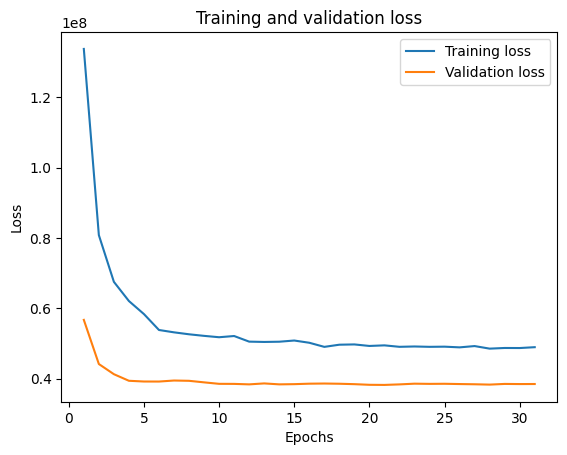

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label="Training loss")
plt.plot(epochs, val_loss_values, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1,1), np.array(y_pred).reshape(-1,1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
predictions = model.predict(X_train)

mean_absolute_percentage_error(y_train, predictions)

78/78 [==============================] - 0s 681us/step


117.39901077085099

In [ ]:
with open('dnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: C:\Users\YIXUAN~1\AppData\Local\Temp\tmprv6nx8l5\assets


INFO:tensorflow:Assets written to: C:\Users\YIXUAN~1\AppData\Local\Temp\tmprv6nx8l5\assets


In [ ]:
with open('dnn_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

predictions = loaded_model.predict(X)
print(predictions)

97/97 [==============================] - 0s 815us/step
[[ -264.07028 ]
 [   78.94967 ]
 [   25.923164]
 ...
 [ -607.61725 ]
 [-1323.944   ]
 [  421.96414 ]]


In [ ]:
# Define parameters
params = {
    'length': len(X),
    'dim': X.shape[1],
    'col': X.columns
}

# Initialize the Knockoffs object
knockoff_generator = Knockoffs()

# Generate knockoff variables
knockoff_variables = knockoff_generator.GenKnockoffs(X.values, params)

# Convert to DataFrame for easier handling
X_knockoff = pd.DataFrame(knockoff_variables, columns=X.columns)

print(X_knockoff.head())

   Peak viewers  Final price  is_historical_low  Peak viewers_shift_1  \
0  -9896.368631     0.021355           0.953520           1625.481194   
1  12097.191319     4.800818           0.868388         -24729.132350   
2 -37063.012372    -5.327552           1.018607           3529.545815   
3   2029.839313     0.438290           0.980759          10105.333343   
4  30912.659539     3.235822           0.882713          -1895.142824   

   Peak viewers_shift_2  Peak viewers_shift_3  Peak viewers_shift_4  \
0           3689.314329          -4164.095881         -22687.868337   
1          22763.465746          -4744.953189           -364.661512   
2          32856.705704           5312.376319           9991.578151   
3           8132.120906          -1434.288030           -365.175369   
4          -3162.516842          -1849.245304          11849.058761   

   Peak viewers_shift_5  Peak viewers_shift_6  Peak viewers_shift_7  ...  \
0          36310.476081          10765.067604          -28

In [ ]:
import torch

from diagnostics import compute_diagnostics, ScatterCovariance

# Assuming X and X_knockoff are your original and knockoff variables

# Define alphas for MMD
alphas = [1., 2., 4., 8., 16., 32., 64., 128.]

# Convert data to torch tensors
X_t = torch.from_numpy(X.values).float()
X_knockoff_t = torch.from_numpy(X_knockoff.values).float()

# Compute diagnostics
results = compute_diagnostics(X_t, X_knockoff_t, alphas, verbose=True)
print(results)

(Self-corr) : 0.564726
Covariance.    Full swap: 41729390975029084160.000000
     MMD.    Full swap: 0.000000
     KNN.    Full swap: 0.852104
  Energy.    Full swap: 4373.484375
Covariance. Partial swap: 42693653876495613952.000000
     MMD. Partial swap: 0.000000
     KNN. Partial swap: 0.777994
  Energy. Partial swap: 4218.953125
       Metric     Swap         Value
0  Covariance     self  5.647262e-01
1  Covariance     full  4.172939e+19
2         MMD     full  0.000000e+00
3         KNN     full  8.521036e-01
4      Energy     full  4.373484e+03
5  Covariance  partial  4.269365e+19
6         MMD  partial  0.000000e+00
7         KNN  partial  7.779935e-01
8      Energy  partial  4.218953e+03


In [ ]:
def causal_inference_knockoff(X, y, X_knockoff, final_model, params):
    """
    Perform causal inference using knockoff intervention.

    Args:
    X: np.ndarray - Original features.
    y: np.ndarray - Target variable.
    X_knockoff: np.ndarray - Knockoff features.
    final_model: Trained model to predict y from X.
    params: dict - Dictionary of parameters.

    Returns:
    causal_matrix: np.ndarray - Thresholded causal matrix.
    p_matrix: np.ndarray - Matrix of p-values.
    """

    # Convert X and X_knockoff to numpy arrays if they are pandas DataFrames
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(X_knockoff, pd.DataFrame):
        X_knockoff = X_knockoff.values

    training_length = params.get('train_len')
    prediction_length = params.get('pred_len')
    num_windows = params.get('num_sliding_win')
    step_size = params.get('step_size')
    columns = params.get('col', [f'X{i}' for i in range(X.shape[1])])  # Default to 'X0', 'X1', ..., if 'col' is not provided
    num_samples = params.get('num_samples')

    if not training_length or not prediction_length or not num_windows or not step_size:
        raise ValueError("Missing required parameters in 'params' dictionary.")

    if not pathlib.Path(final_model).exists():
        raise FileNotFoundError(f"Model file {final_model} does not exist.")

    with open(final_model, 'rb') as f:
        model = pickle.load(f)

    causal_decisions = []
    p_values = []

    for i in range(X.shape[1]):
        feature_name = columns[i]
        print(f"Testing feature '{feature_name}' against target 'y'...")

        knockoff_sample = X_knockoff[:, i]
        mean = np.random.normal(0, 0.05, len(knockoff_sample)) + np.mean(X[:, i])
        outdist = np.random.normal(150, 120, len(knockoff_sample))
        uniform = np.random.uniform(np.min(X[:, i]), np.max(X[:, i]), len(knockoff_sample))
        interventionlist = [knockoff_sample, outdist[: len(knockoff_sample)], mean, uniform]
        intervention_methods = ['In-dist', 'Out-dist', 'Mean', 'Uniform']

        for m, intervene in enumerate(interventionlist):
            mselist, mselistint, mapelist, mapelistint = [], [], [], []
            for iter in range(num_windows):
                start = iter * step_size
                end = start + training_length + prediction_length

                X_train = X[start:start + training_length, :]
                y_train = y[start:start + training_length]
                X_test = X[start + training_length:end, :]
                y_test = y[start + training_length:end]

                X_test_int = X_test.copy()
                X_test_int[:, i] = intervene[start + training_length:end]

                y_pred = model.predict(X_test)
                y_pred_int = model.predict(X_test_int)

                mse = mean_squared_error(y_test, y_pred)
                mape = mean_absolute_percentage_error(y_test, y_pred)
                mseint = mean_squared_error(y_test, y_pred_int)
                mapeint = mean_absolute_percentage_error(y_test, y_pred_int)

                mselist.append(mse)
                mapelist.append(mape)
                mselistint.append(mseint)
                mapelistint.append(mapeint)

            # Statistical tests
            t, p = ks_2samp(mapelist, mapelistint)
            corr, p_val = spearmanr(mapelist, mapelistint)

            print(f"  Method: {intervention_methods[m]}, KS p-value: {p:.4f}, Spearman p-value: {p_val:.4f}")

            if p < 0.05:
                causal_decision = 1
            else:
                causal_decision = 0

            causal_decisions.append(causal_decision)
            p_values.append(p)

    # Reshape results into a matrix
    causal_matrix = np.array(causal_decisions).reshape(X.shape[1], len(intervention_methods))
    p_matrix = np.array(p_values).reshape(X.shape[1], len(intervention_methods))

    # Print summary
    print("\nCausal Inference Summary:")
    for i in range(X.shape[1]):
        feature_name = columns[i]
        print(f"Feature '{feature_name}':")
        for m in range(len(intervention_methods)):
            print(f"  {intervention_methods[m]} - Causal Decision: {causal_matrix[i, m]}, P-Value: {p_matrix[i, m]:.4f}")

    return causal_matrix, p_matrix

# Example usage:
# params = {
#     'train_len': 100,
#     'pred_len': 10,
#     'num_sliding_win': 30,
#     'step_size': 10,
#     'col': ['X1', 'X2', 'X3', 'X4'],
#     'num_samples': 50
# }
# causal_matrix, p_matrix = causal_inference_knockoff(X, y, X_knockoff, 'final_model.pkl', params)



In [ ]:
default_params = {
    'plot_path' : 'C:\\Users\\Yixuan Liu\\Downloads\\DSO 585',
    'epochs': 50,
    'pred_len': 12,
    'train_len': 500,
    'num_layers': 4,
    'num_samples': 40,
    'num_cells': 20,
    'dropout_rate': 0.1,
    'win_size': 1,
    'step_size': 3,
    'num_sliding_win': 20,
    'sliding_win_size': 100,
    'dim': 5,
    'batch_size': 32
}

In [ ]:
causal_matrix, p_matrix = causal_inference_knockoff(X, y, X_knockoff, 'dnn_model.pkl', default_params)

Testing feature 'X0' against target 'y'...
1/1 [==============================] - 0s 17ms/step
  Method: In-dist, KS p-value: 0.8320, Spearman p-value: 0.0021
1/1 [==============================] - 0s 18ms/step
  Method: Out-dist, KS p-value: 0.5713, Spearman p-value: 0.0002
1/1 [==============================] - 0s 19ms/step
  Method: Mean, KS p-value: 0.5713, Spearman p-value: 0.0006
1/1 [==============================] - 0s 17ms/step
  Method: Uniform, KS p-value: 0.0000, Spearman p-value: 0.0910
Testing feature 'X1' against target 'y'...
1/1 [==============================] - 0s 18ms/step
  Method: In-dist, KS p-value: 1.0000, Spearman p-value: 0.0000
1/1 [==============================] - 0s 17ms/step
  Method: Out-dist, KS p-value: 0.8320, Spearman p-value: 0.0000
1/1 [==============================] - 0s 18ms/step
  Method: Mean, KS p-value: 1.0000, Spearman p-value: 0.0000
1/1 [==============================] - 0s 17ms/step
  Method: Uniform, KS p-value: 1.0000, Spearman p-valu

In [ ]:
# Print the results
print("Causal Matrix (Thresholded):")
print(causal_matrix)
print("P-Value Matrix:")
print(p_matrix)

Causal Matrix (Thresholded):
[[0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 0 0 1]
 [0 0 0 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 1 1 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
P-Value Matrix:
[[8.31969611e-01 5.71336005e-01 5.71336005e-01 9.54696510e-06]
 [1.00000000e+00 8.31969611e-01 1.00000000e+00 9.99992393e-01]
 [1.00000000e+00 9.83136877e-01 1.00000000e+00 1.00000000e+00]
 [3.35590981e-01 8.31969611e-01 8.31969611e-01 5.56906298e-05]
 [3.35590981e-01 5.71336005e-01 5.71336005e-01 3.96729439e-03]
 [5.71336005e-01 8.10577116e-02 8.10577116e-02 3.35416594e-02]
 [8.10577116e-02 8.31969611e-01 8.31969611e-01 2.70497345e-04]
 [3.35416594e-02 3.35590981e-01 3.35590981e-01 1.22986126e-02]
 [2.70497345e-04 3.35590981e-01 3.35590981e-01 3.96729439e-03]
 [1.22986126e-02 8.31969

In [ ]:
# Create a dataframe to match the column names with the output
causal_df = pd.DataFrame(causal_matrix, index=params['col'], columns=['In-dist', 'Out-dist', 'Mean', 'Uniform'])
p_values_df = pd.DataFrame(p_matrix, index=params['col'], columns=['In-dist', 'Out-dist', 'Mean', 'Uniform'])


In [ ]:
causal_df

In-dist  Out-dist  Mean  Uniform
Peak viewers                     0         0     0        1
Final price                      0         0     0        0
is_historical_low                0         0     0        0
Peak viewers_shift_1             0         0     0        1
Peak viewers_shift_2             0         0     0        1
Peak viewers_shift_3             0         0     0        1
Peak viewers_shift_4             0         0     0        1
Peak viewers_shift_5             1         0     0        1
Peak viewers_shift_6             1         0     0        1
Peak viewers_shift_7             1         0     0        1
Peak viewers_shift_8             0         0     0        0
Peak viewers_shift_9             0         1     1        1
Peak viewers_shift_10            1         0     0        0
Peak viewers_shift_11            1         1     1        1
Peak viewers_shift_12            0         0     0        0
Peak viewers_shift_13            0         0     0        1
Peak viewers_shift_14            0         0     0        1
Rating_shift_1                   0         0     0        0
Rating_shift_7                   0         0     0        0
Final price_shift_1              0         0     0        0
Final price_shift_2              0         0     0        0
Final price_shift_3              0         0     0        0
Final price_shift_4              0         0     0        0
Final price_shift_5              0         0     0        0
Final price_shift_6              0         0     0        0
Final price_shift_7              0         0     0        0
is_historical_low_shift_1        0         0     0        0
is_historical_low_shift_2        0         0     0        0
is_historical_low_shift_3        0         0     0        0
is_historical_low_shift_4        0         0     0        0
is_historical_low_shift_5        0         0     0        0
is_historical_low_shift_6        0         0     0        0
is_historical_low_shift_7        0         0     0        0

In [ ]:
p_values_df

In-dist  Out-dist      Mean       Uniform
Peak viewers               0.831970  0.571336  0.571336  9.546965e-06
Final price                1.000000  0.831970  1.000000  9.999924e-01
is_historical_low          1.000000  0.983137  1.000000  1.000000e+00
Peak viewers_shift_1       0.335591  0.831970  0.831970  5.569063e-05
Peak viewers_shift_2       0.335591  0.571336  0.571336  3.967294e-03
Peak viewers_shift_3       0.571336  0.081058  0.081058  3.354166e-02
Peak viewers_shift_4       0.081058  0.831970  0.831970  2.704973e-04
Peak viewers_shift_5       0.033542  0.335591  0.335591  1.229861e-02
Peak viewers_shift_6       0.000270  0.335591  0.335591  3.967294e-03
Peak viewers_shift_7       0.012299  0.831970  0.571336  5.569063e-05
Peak viewers_shift_8       0.174533  0.571336  0.571336  8.105771e-02
Peak viewers_shift_9       0.081058  0.033542  0.033542  5.569063e-05
Peak viewers_shift_10      0.033542  0.081058  0.081058  8.105771e-02
Peak viewers_shift_11      0.003967  0.012299  0.012299  1.433478e-07
Peak viewers_shift_12      0.335591  0.571336  0.571336  8.105771e-02
Peak viewers_shift_13      0.571336  0.335591  0.335591  1.325967e-06
Peak viewers_shift_14      0.983137  0.983137  0.983137  9.546965e-06
Rating_shift_1             1.000000  0.999992  1.000000  1.000000e+00
Rating_shift_7             1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_1        1.000000  0.999992  1.000000  9.999924e-01
Final price_shift_2        1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_3        1.000000  0.983137  1.000000  1.000000e+00
Final price_shift_4        1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_5        1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_6        1.000000  0.831970  1.000000  9.999924e-01
Final price_shift_7        1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_1  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_2  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_3  1.000000  0.983137  1.000000  1.000000e+00
is_historical_low_shift_4  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_5  1.000000  0.983137  1.000000  1.000000e+00
is_historical_low_shift_6  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_7  1.000000  0.983137  1.000000  1.000000e+00

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import ks_2samp, spearmanr
import pickle
import pandas as pd
import pathlib
import tensorflow as tf
from tensorflow.keras.models import load_model

def plot_mape_distributions_for_variable(X, y, X_knockoff, final_model_path, params, variable_index):
    """
    Plot the MAPE distributions comparing original and knockoff interventions for a specific variable.

    Args:
    X: np.ndarray or pd.DataFrame - Original features.
    y: np.ndarray or pd.Series - Target variable.
    X_knockoff: np.ndarray or pd.DataFrame - Knockoff features.
    final_model_path: str - Path to the trained model file.
    params: dict - Dictionary of parameters.
    variable_index: int - Index of the variable to test.
    """
    # Convert X, y, and X_knockoff to numpy arrays if they are pandas DataFrames
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    if isinstance(X_knockoff, pd.DataFrame):
        X_knockoff = X_knockoff.values

    plot_path = params.get('plot_path')
    training_length = params['train_len']
    prediction_length = params['pred_len']
    num_windows = params['num_sliding_win']
    step_size = params['step_size']
    columns = params.get('col', [f'X{i}' for i in range(X.shape[1])])  # Default to 'X0', 'X1', ..., if 'col' is not provided

    feature_name = columns[variable_index]

    # Load the model (handle both traditional pickled models and Keras models)
    if final_model_path.endswith('.pkl'):
        with open(final_model_path, 'rb') as f:
            model = pickle.load(f)
    else:
        model = load_model(final_model_path)

    knockoff_sample = X_knockoff[:, variable_index]
    mean = np.random.normal(0, 0.05, len(knockoff_sample)) + np.mean(X[:, variable_index])
    outdist = np.random.normal(150, 120, len(knockoff_sample))
    uniform = np.random.uniform(np.min(X[:, variable_index]), np.max(X[:, variable_index]), len(knockoff_sample))
    interventionlist = [knockoff_sample, outdist[: len(knockoff_sample)], mean, uniform]
    intervention_methods = ['In-dist', 'Out-dist', 'Mean', 'Uniform']

    mapelist = {method: [] for method in intervention_methods}
    mapelistint = {method: [] for method in intervention_methods}

    for m, intervene in enumerate(interventionlist):
        for iter in range(num_windows):
            start = iter * step_size
            end = start + training_length + prediction_length

            X_train = X[start:start + training_length, :]
            y_train = y[start:start + training_length]
            X_test = X[start + training_length:end, :]
            y_test = y[start + training_length:end]

            X_test_int = X_test.copy()
            X_test_int[:, variable_index] = intervene[start + training_length:end]

            y_pred = model.predict(X_test,verbose = 0)
            y_pred_int = model.predict(X_test_int, verbose = 0)

            mape = mean_absolute_percentage_error(y_test, y_pred)
            mapeint = mean_absolute_percentage_error(y_test, y_pred_int)

            mapelist[intervention_methods[m]].append(mape)
            mapelistint[intervention_methods[m]].append(mapeint)

    # Plot MAPE distributions for the specified variable
    plt.figure(figsize=(14, 7))
    for i, method in enumerate(intervention_methods):
        plt.subplot(2, 2, i+1)
        sns.kdeplot(mapelist[method], label='Original', color='blue', shade=True)
        sns.kdeplot(mapelistint[method], label='Knockoff', color='red', shade=True)
        plt.title(f"MAPE Distribution for {method}")
        plt.xlabel("MAPE")
        plt.ylabel("Density")
        plt.legend()

    plt.suptitle(f"MAPE Distributions for Feature '{feature_name}'")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{plot_path}/mape_distributions_{feature_name}.png")
    plt.show()

# Example usage:
# params = {
#     'train_len': 100,
#     'pred_len': 10,
#     'num_sliding_win': 30,
#     'step_size': 10,
#     'plot_path': './plots/',
#     'col': ['X1', 'X2', 'X3', 'X4'],
#     'num_samples': 50
# }
# plot_mape_distributions_for_variable(X, y, X_knockoff, 'dnn_model.pkl', params, variable_index=7)


In [ ]:
default_params = {
    'plot_path' : 'C:\\Users\\Yixuan Liu\\Downloads\\DSO 585',
    'epochs': 50,
    'pred_len': 12,
    'train_len': 500,
    'num_layers': 4,
    'num_samples': 40,
    'num_cells': 20,
    'dropout_rate': 0.1,
    'win_size': 1,
    'step_size': 3,
    'num_sliding_win': 20,
    'sliding_win_size': 100,
    'dim': 5,
    'batch_size': 32
}

In [ ]:
indices_with_in_dist_1 = causal_df.reset_index().index[causal_df['In-dist'] == 1].tolist()
variables_with_in_dist_1 = causal_df.index[causal_df['In-dist'] == 1].tolist()

In [ ]:
variables_with_in_dist_1

['Peak viewers_shift_5',
 'Peak viewers_shift_6',
 'Peak viewers_shift_7',
 'Peak viewers_shift_10',
 'Peak viewers_shift_11']

In [ ]:
indices_with_in_dist_1

[7, 8, 9, 12, 13]

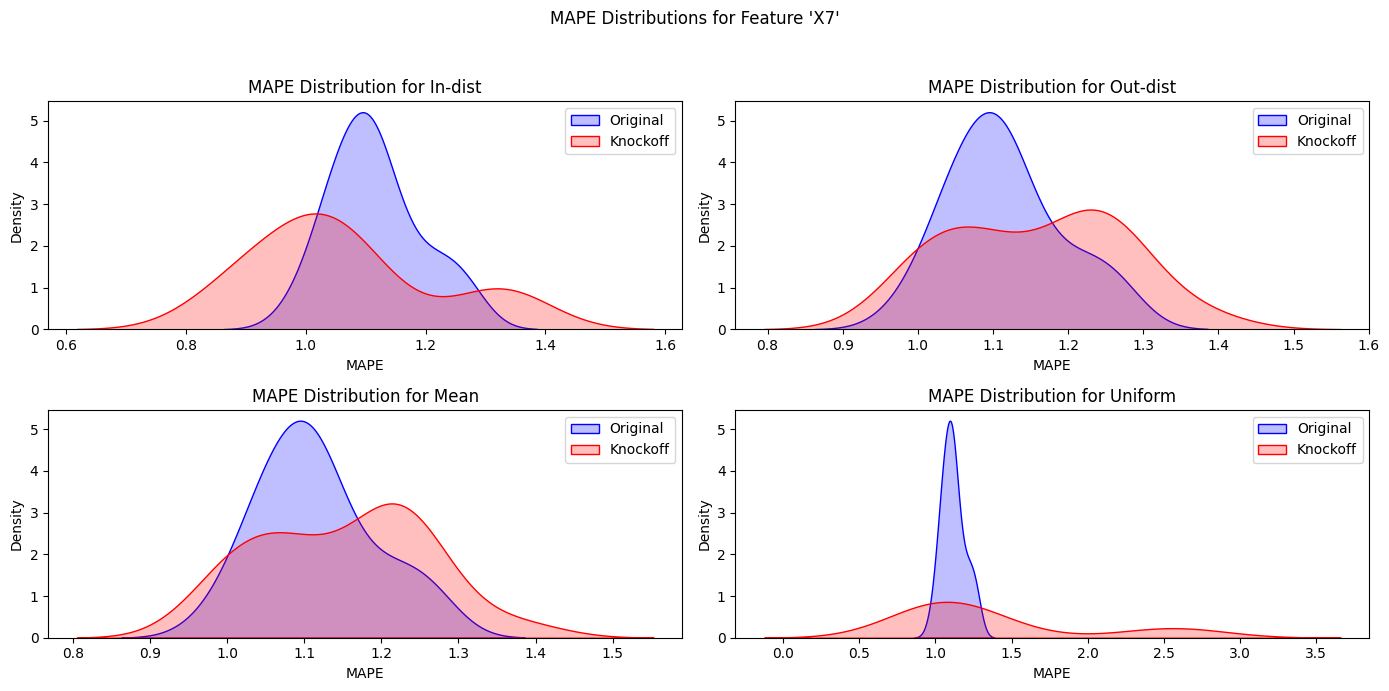

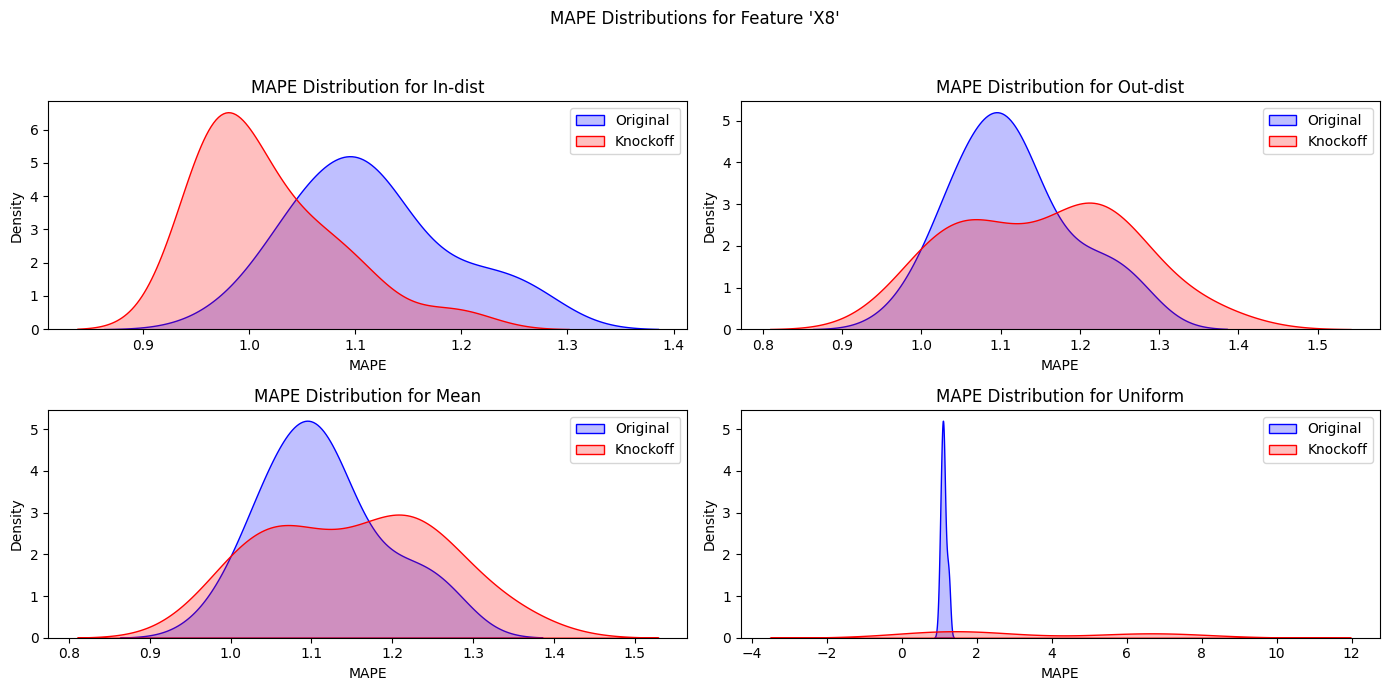

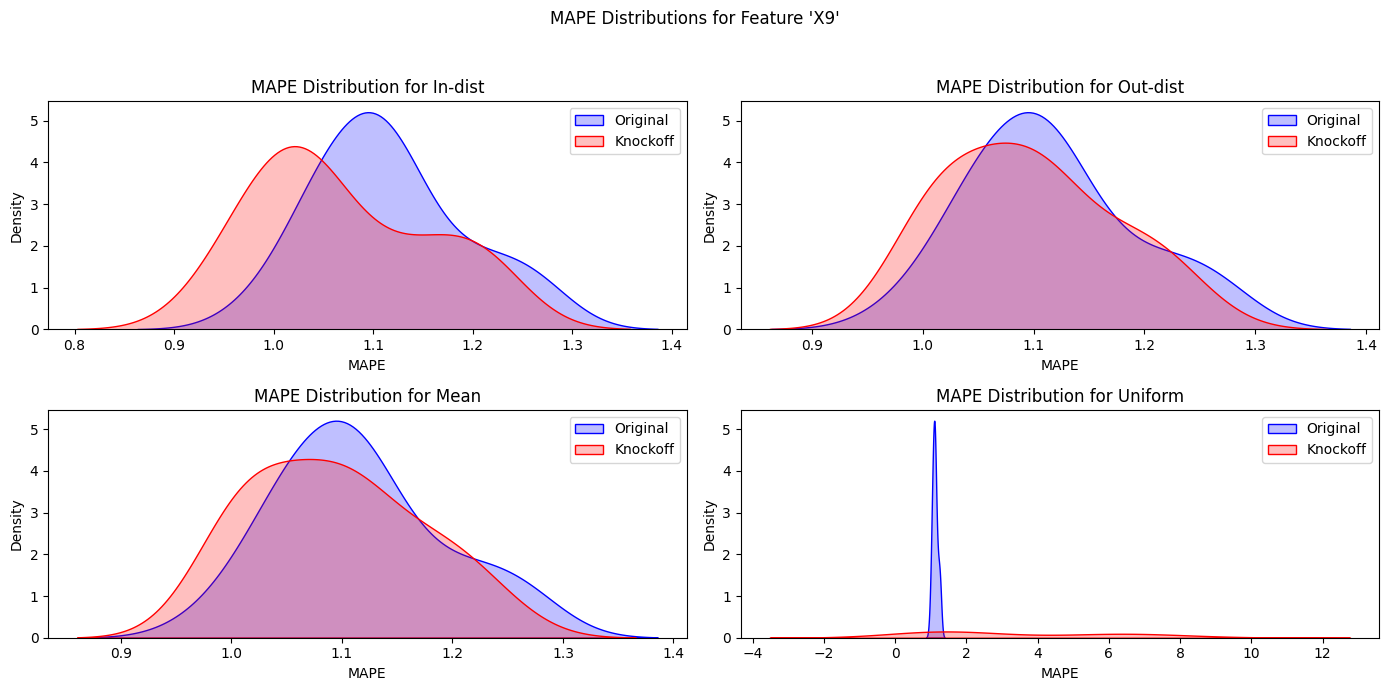

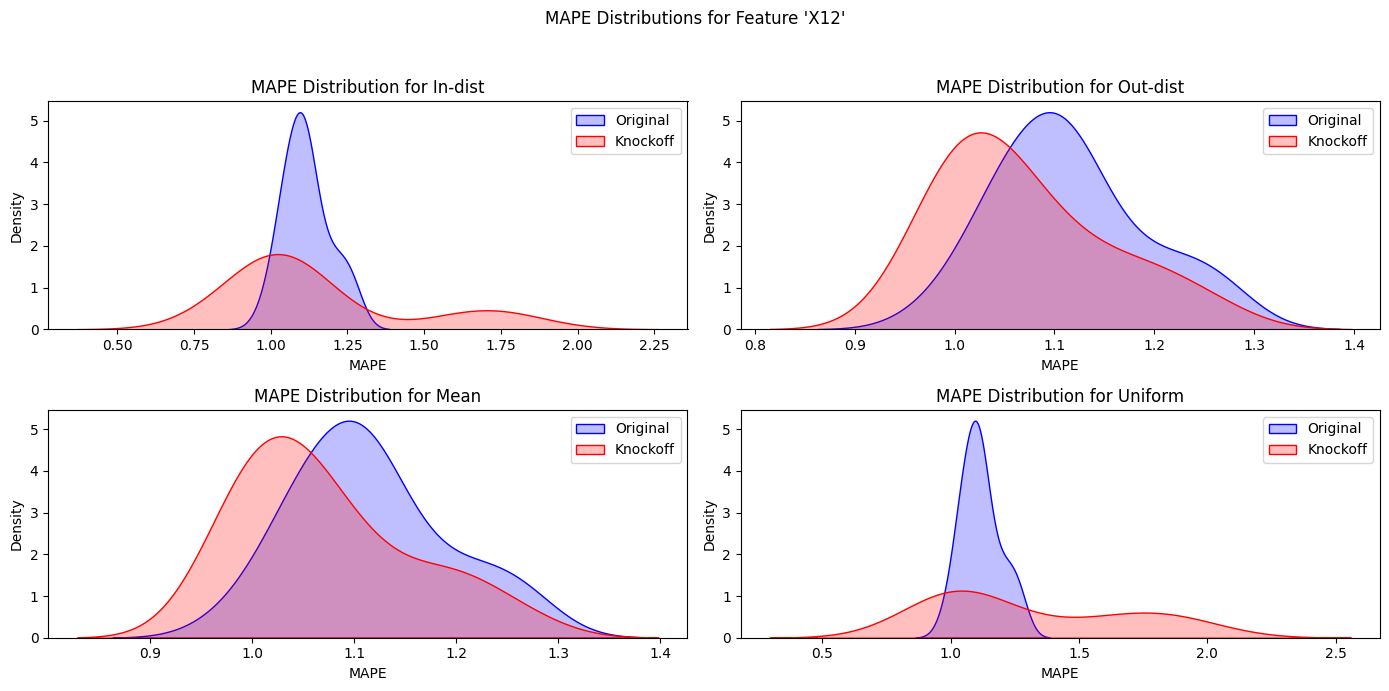

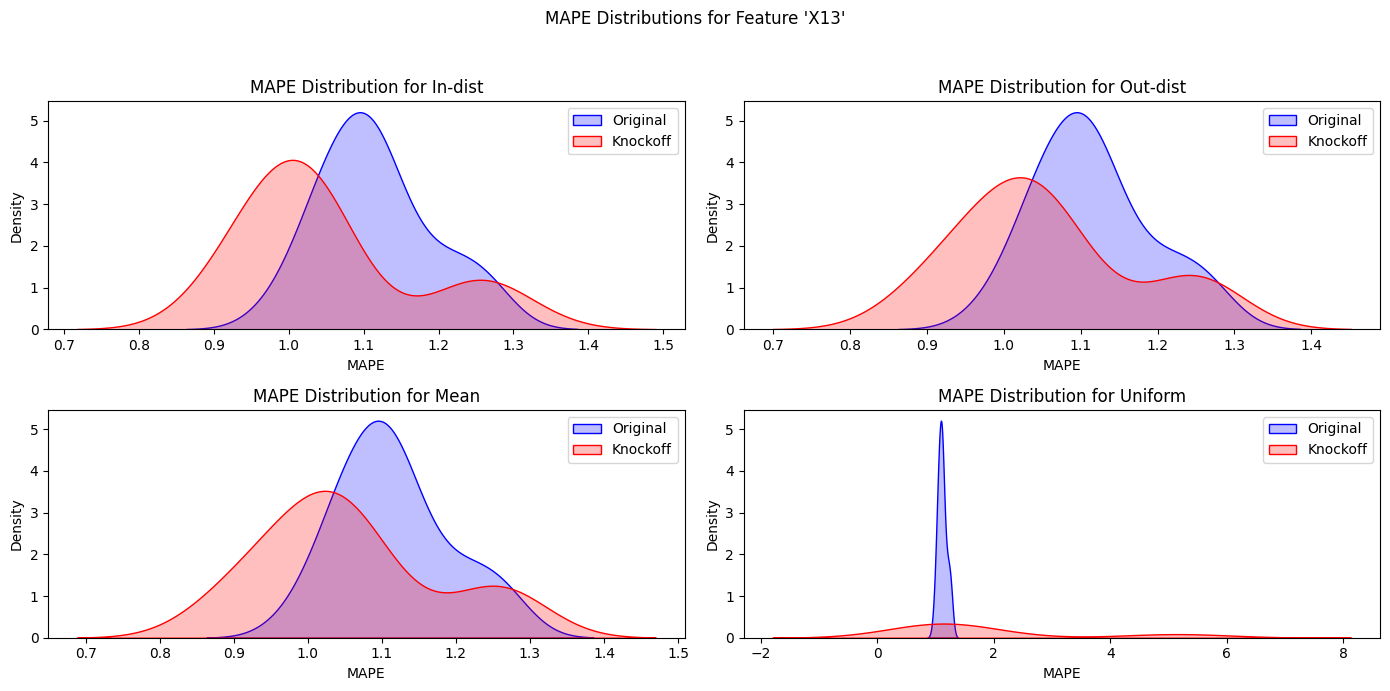

In [ ]:
for i in range(len(indices_with_in_dist_1)):
    plot_mape_distributions_for_variable(X, y, X_knockoff, 'dnn_model.pkl', default_params, indices_with_in_dist_1[i])

# 5. LPCMCI

In [ ]:
data = raw[['DateTime', 'Players', 'Peak viewers']]

In [ ]:
data.loc[:, 'DateTime'] = pd.to_datetime(data['DateTime'], format='%m/%d/%y')

In [ ]:
data = data.set_index('DateTime')

In [ ]:
data = data.dropna()

In [ ]:
data_diff = data.diff()

In [ ]:
data_diff = data_diff.dropna()

<Axes: xlabel='DateTime'>

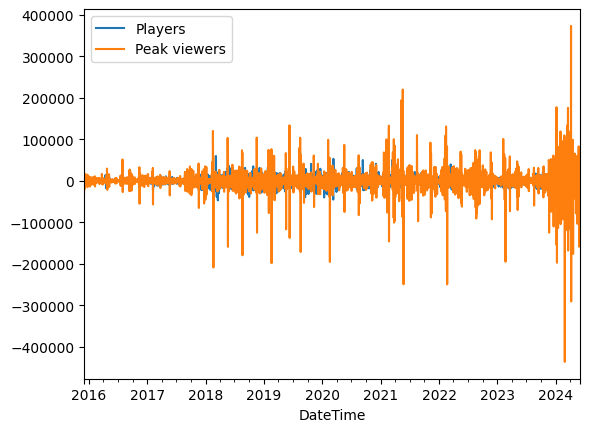

In [ ]:
data_diff.plot()

In [ ]:
Players = data_diff[['Players']]
Viewers = data_diff[['Peak viewers']]

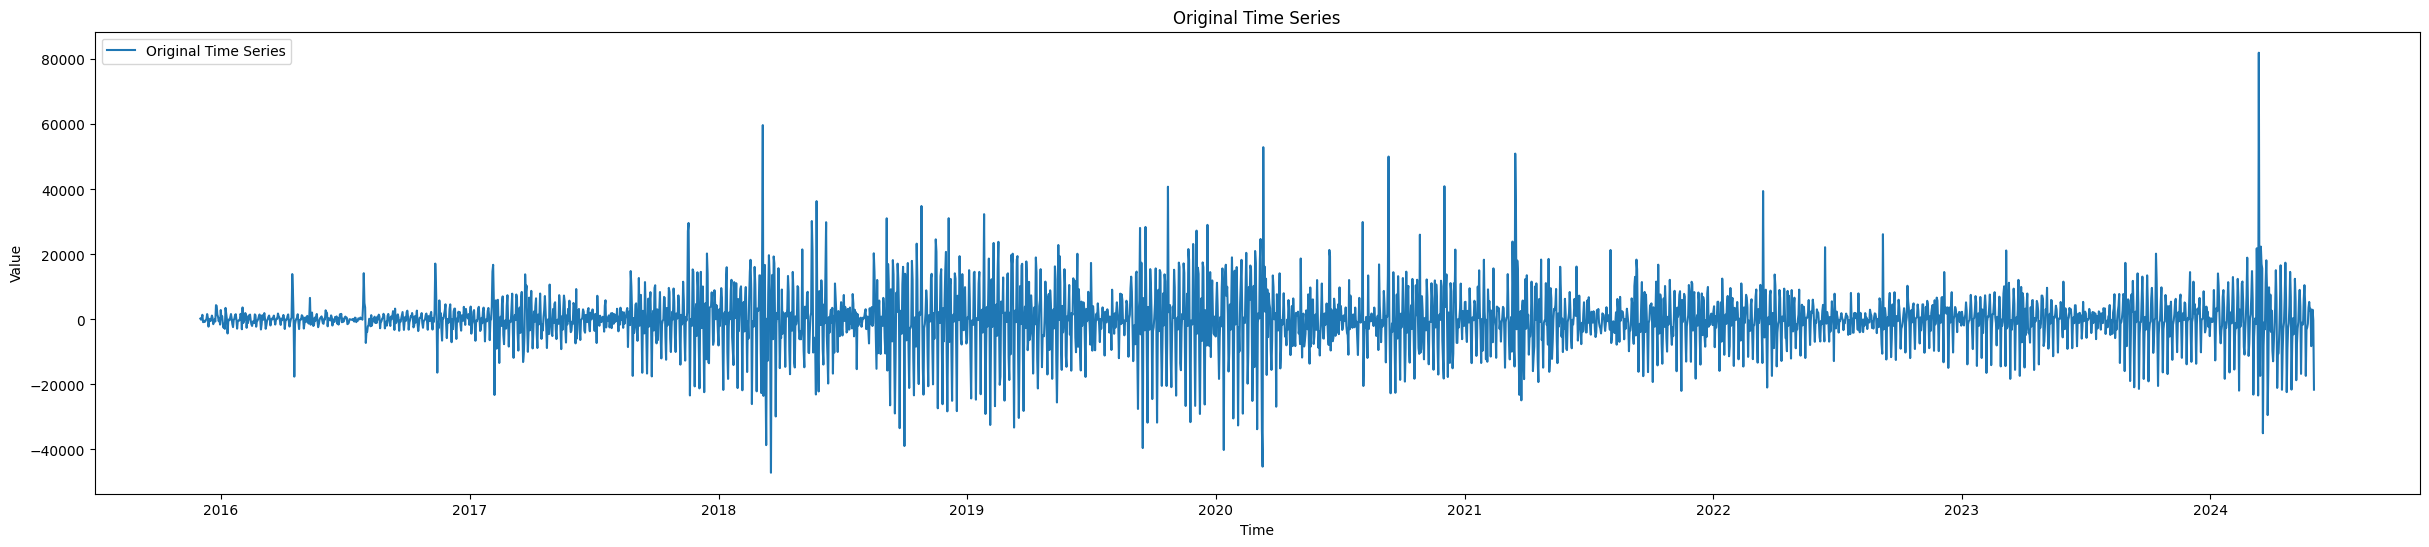

In [ ]:
# Plot the original time series
plt.figure(figsize=(30, 6))
plt.plot(Players, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

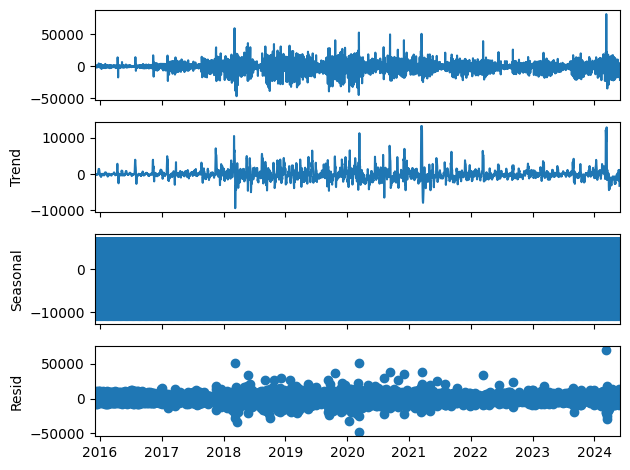

In [ ]:
# Decompose the time series
result = seasonal_decompose(Players, model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [ ]:
# Deseasonalize the time series
deseasonalized_player = Players['Players'] - result.seasonal

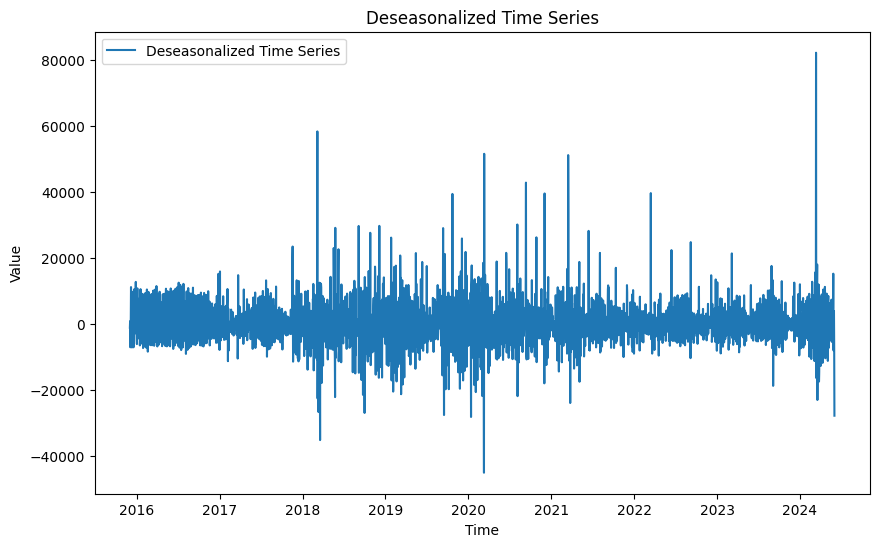

In [ ]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_player, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
viewer = data_diff['Peak viewers']

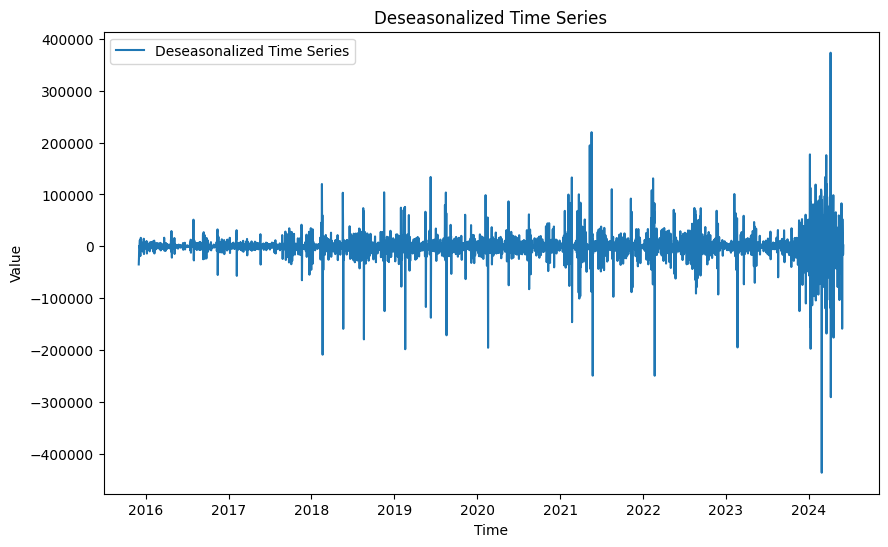

In [ ]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(viewer, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
df = pd.concat([deseasonalized_player, viewer], axis=1)

In [ ]:
df.columns = ['deseasonalized_player_diff', 'viewer_diff']

In [ ]:
type(df['deseasonalized_player_diff'].values)

numpy.ndarray

In [ ]:
dt = np.column_stack((df['viewer_diff'].values, df['deseasonalized_player_diff'].values))

In [ ]:
dt

array([[-34919.        ,  -1215.01411028],
       [-21350.        ,    768.91617932],
       [   509.        ,  -7148.27871402],
       ...,
       [ 25516.        ,   3821.91617932],
       [-16095.        ,  -7609.27871402],
       [  1891.        , -27886.72259142]])

In [ ]:
var_names = ['viewer_diff', 'deseasonalized_player_diff']

In [ ]:
dataframe = pp.DataFrame(dt, var_names=var_names)
tau_max = 14

# Set up PCMCI with ParCorr (Partial Correlation) as the independence test
parcorr = ParCorr(significance='analytic')
lpcmci = LPCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=1)

# Run Latent PCMCI (this step is a placeholder; actual implementation may vary)
results = lpcmci.run_lpcmci(tau_max=tau_max, pc_alpha=0.05)


Starting preliminary phase  1

Starting test phase

p = 0
(0,-14) independent (0, 0) given () union set()
(0,-10) independent (0, 0) given () union set()
(0,-8) independent (0, 0) given () union set()
(0,-7) independent (0, 0) given () union set()
(0,-6) independent (0, 0) given () union set()
(0,-5) independent (0, 0) given () union set()
(1,-1) independent (1, 0) given () union set()
Writing:   (0,-14) oL> (0, 0) ==> (0,-14)     (0, 0) 
Writing:   (0,-10) oL> (0, 0) ==> (0,-10)     (0, 0) 
Writing:   (0,-8) oL> (0, 0) ==> (0,-8)     (0, 0) 
Writing:   (0,-7) oL> (0, 0) ==> (0,-7)     (0, 0) 
Writing:   (0,-6) oL> (0, 0) ==> (0,-6)     (0, 0) 
Writing:   (0,-5) oL> (0, 0) ==> (0,-5)     (0, 0) 
Writing:   (1,-1) oL> (1, 0) ==> (1,-1)     (1, 0) 
(0, 0) independent (1, 0) given () union set()
(0, 0) independent (1, 0) given () union set()
Writing:   (0, 0) o?o (1, 0) ==> (0, 0)     (1, 0) 
Writing:   (1, 0) o?o (0, 0) ==> (1, 0)     (0, 0) 
(0,-2) independent (1, 0) given () union set

In [ ]:
p_matrix = results['p_matrix']
print(results['p_matrix'].round(2))

[[[0.   0.   0.   0.   0.   0.   0.01 0.86 0.68 0.19 0.58 0.   0.45 0.
   0.  ]
  [0.3  0.04 0.33 0.3  0.98 1.   0.4  0.63 0.08 1.   0.62 0.56 1.   1.
   0.  ]]

 [[0.3  0.   0.77 0.31 0.87 0.73 0.96 0.31 0.83 0.88 0.78 0.46 0.81 0.92
   0.17]
  [0.   0.48 0.   0.01 0.01 0.   0.94 0.   0.98 0.   0.02 0.07 0.05 0.7
   0.  ]]]


In [ ]:
p_matrix.shape

(2, 2, 15)

In [ ]:
def print_significant_causality(p_matrix, alpha=0.05):
    """
    Prints out significant causal links from the p_matrix.

    Parameters:
    - p_matrix: numpy array of shape (N, N, tau_max+1), p-values of the causal links
    - alpha: significance level to determine significant causality
    """
    N, _, tau_max_plus_1 = p_matrix.shape
    tau_max = tau_max_plus_1 - 1

    print(f"Significant causal links (p < {alpha}):")
    for i in range(N):
        for j in range(N):
            for tau in range(tau_max_plus_1):
                p_value = p_matrix[i, j, tau]
                if p_value < alpha:
                    print(f"Variable {i} at time t-{tau} -> Variable {j} at time t with p-value: {p_value:.5f}")


In [ ]:
print_significant_causality(p_matrix, alpha=0.05)

Significant causal links (p < 0.05):
Variable 0 at time t-0 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-1 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-2 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-3 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-4 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-5 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-6 -> Variable 0 at time t with p-value: 0.01452
Variable 0 at time t-11 -> Variable 0 at time t with p-value: 0.00462
Variable 0 at time t-13 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-14 -> Variable 0 at time t with p-value: 0.00276
Variable 0 at time t-1 -> Variable 1 at time t with p-value: 0.04330
Variable 0 at time t-14 -> Variable 1 at time t with p-value: 0.00213
Variable 1 at time t-1 -> Variable 0 at time t with p-value: 0.00000
Variable 1 at time t-0 -> Variable 1 at time t with p-value: 0

In [ ]:
results['graph']

array([[['', '-->', '-->', '-->', '-->', '-->', '-->', '', '', '', '',
         '-->', '', '-->', '-->'],
        ['', '<->', '', '', '', '', '', '', '', '', '', '', '', '',
         '<->']],

       [['', '-->', '', '', '', '', '', '', '', '', '', '', '', '', ''],
        ['', '', '-->', '<->', '-->', '-->', '', '-->', '', '-->',
         '-->', '', '', '', '-->']]], dtype='<U3')

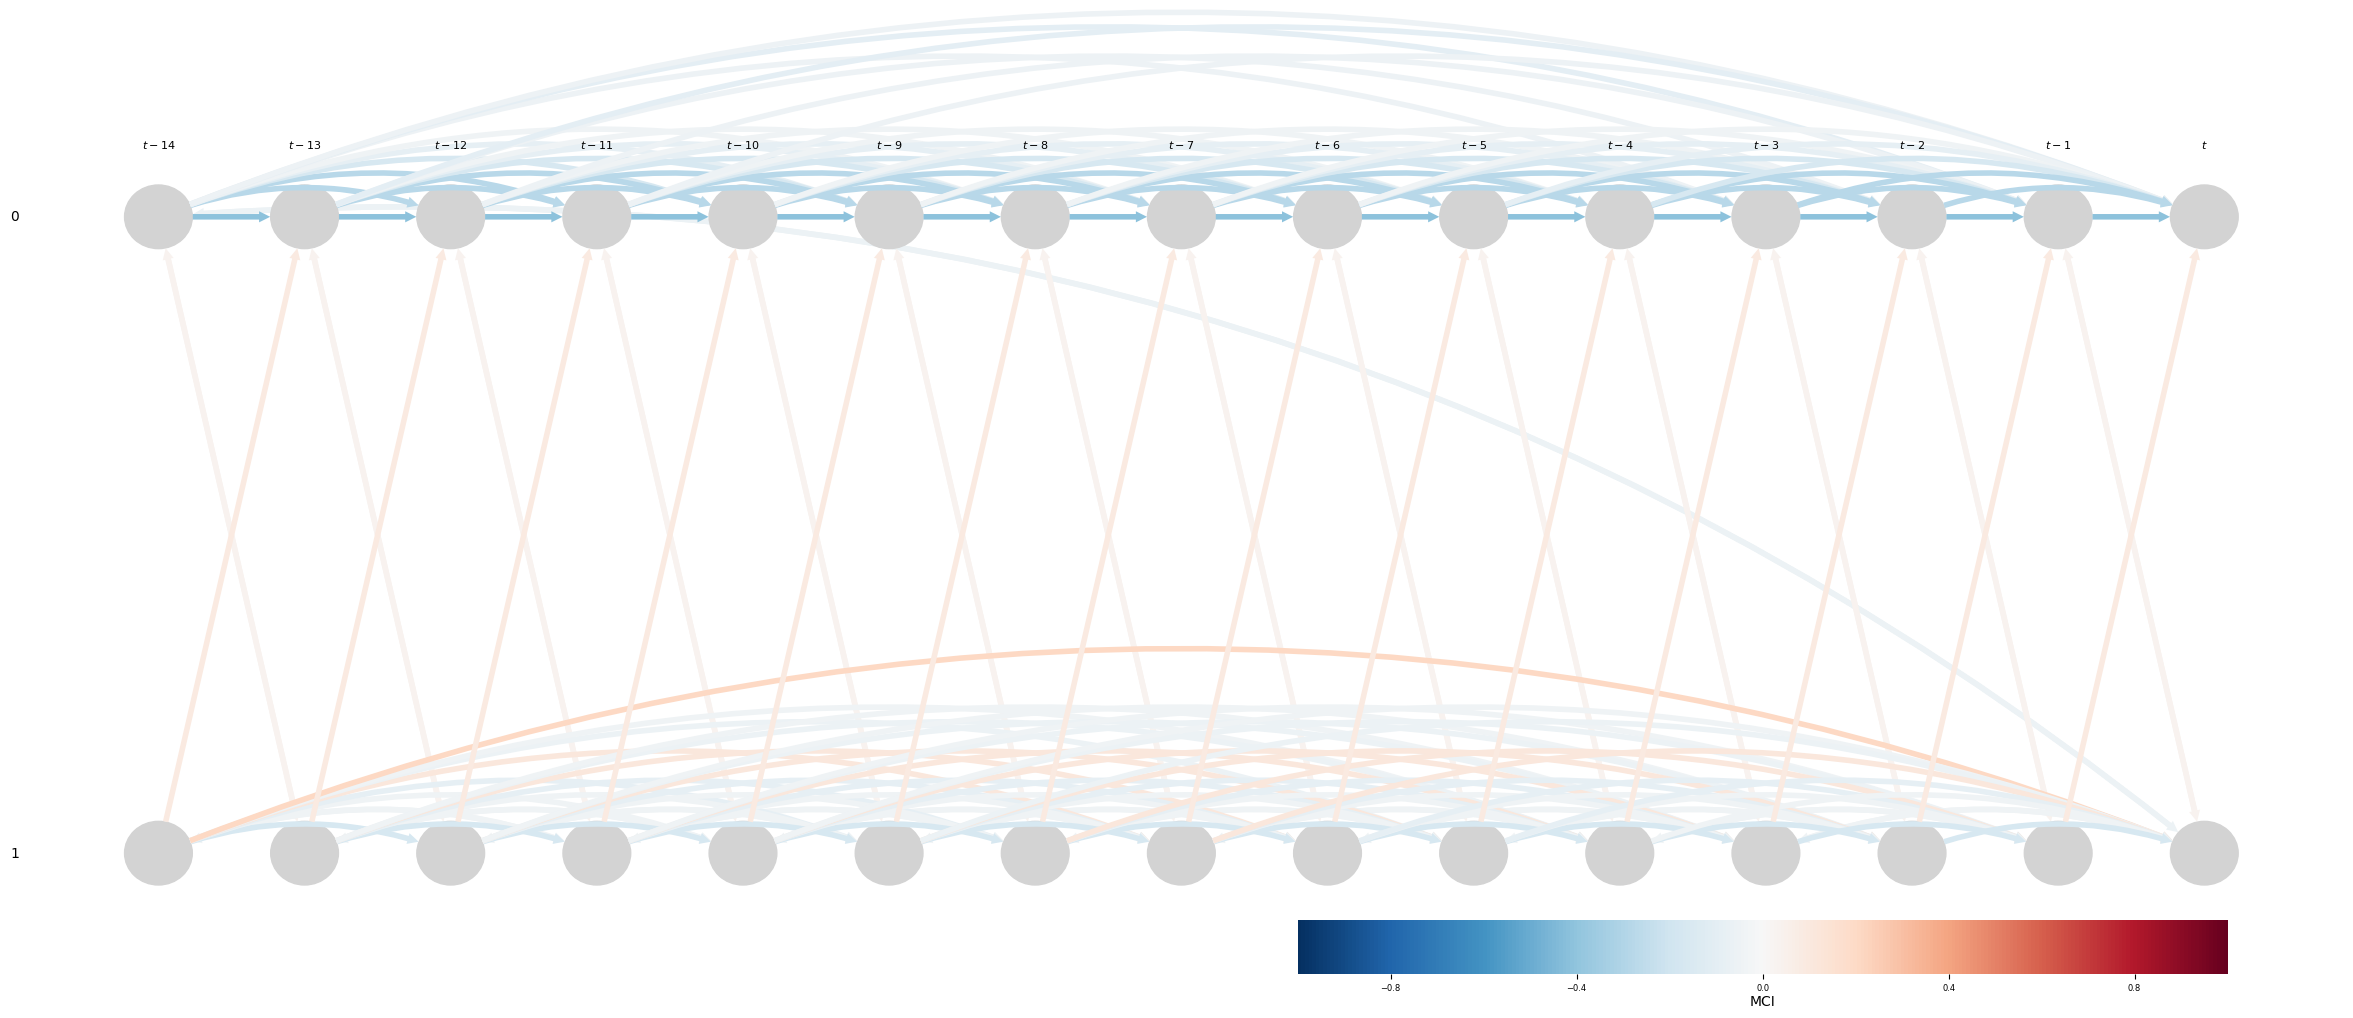

In [ ]:
# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'],
                         figsize = (30,10))
plt.savefig(f"{'C:/Users/Yixuan Liu/Downloads/DSO 585'}/time_series_dag_rainbox_six_siege.png")
plt.show()

In [ ]:
graph = results['graph']

In [ ]:
graph

array([[['', '-->', '-->', '-->', '-->', '-->', '-->', '', '', '', '',
         '-->', '', '-->', '-->'],
        ['', '<->', '', '', '', '', '', '', '', '', '', '', '', '',
         '<->']],

       [['', '-->', '', '', '', '', '', '', '', '', '', '', '', '', ''],
        ['', '', '-->', '<->', '-->', '-->', '', '-->', '', '-->',
         '-->', '', '', '', '-->']]], dtype='<U3')

In [ ]:
simplified_graph = np.array([[['', '', '', '', '', '', '-->', '', '', '', '',
         '-->', '', '', ''],
        ['', '-->', '', '', '', '', '', '', '', '', '', '', '', '',
         '-->']],

       [['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
        ['', '', '-->', '', '', '-->', '', '', '', '-->',
         '', '', '', '', '']]], dtype='<U3')

In [ ]:
(simplified_graph != graph).flatten().sum()

15

In [ ]:
(graph != '').flatten().sum()

20

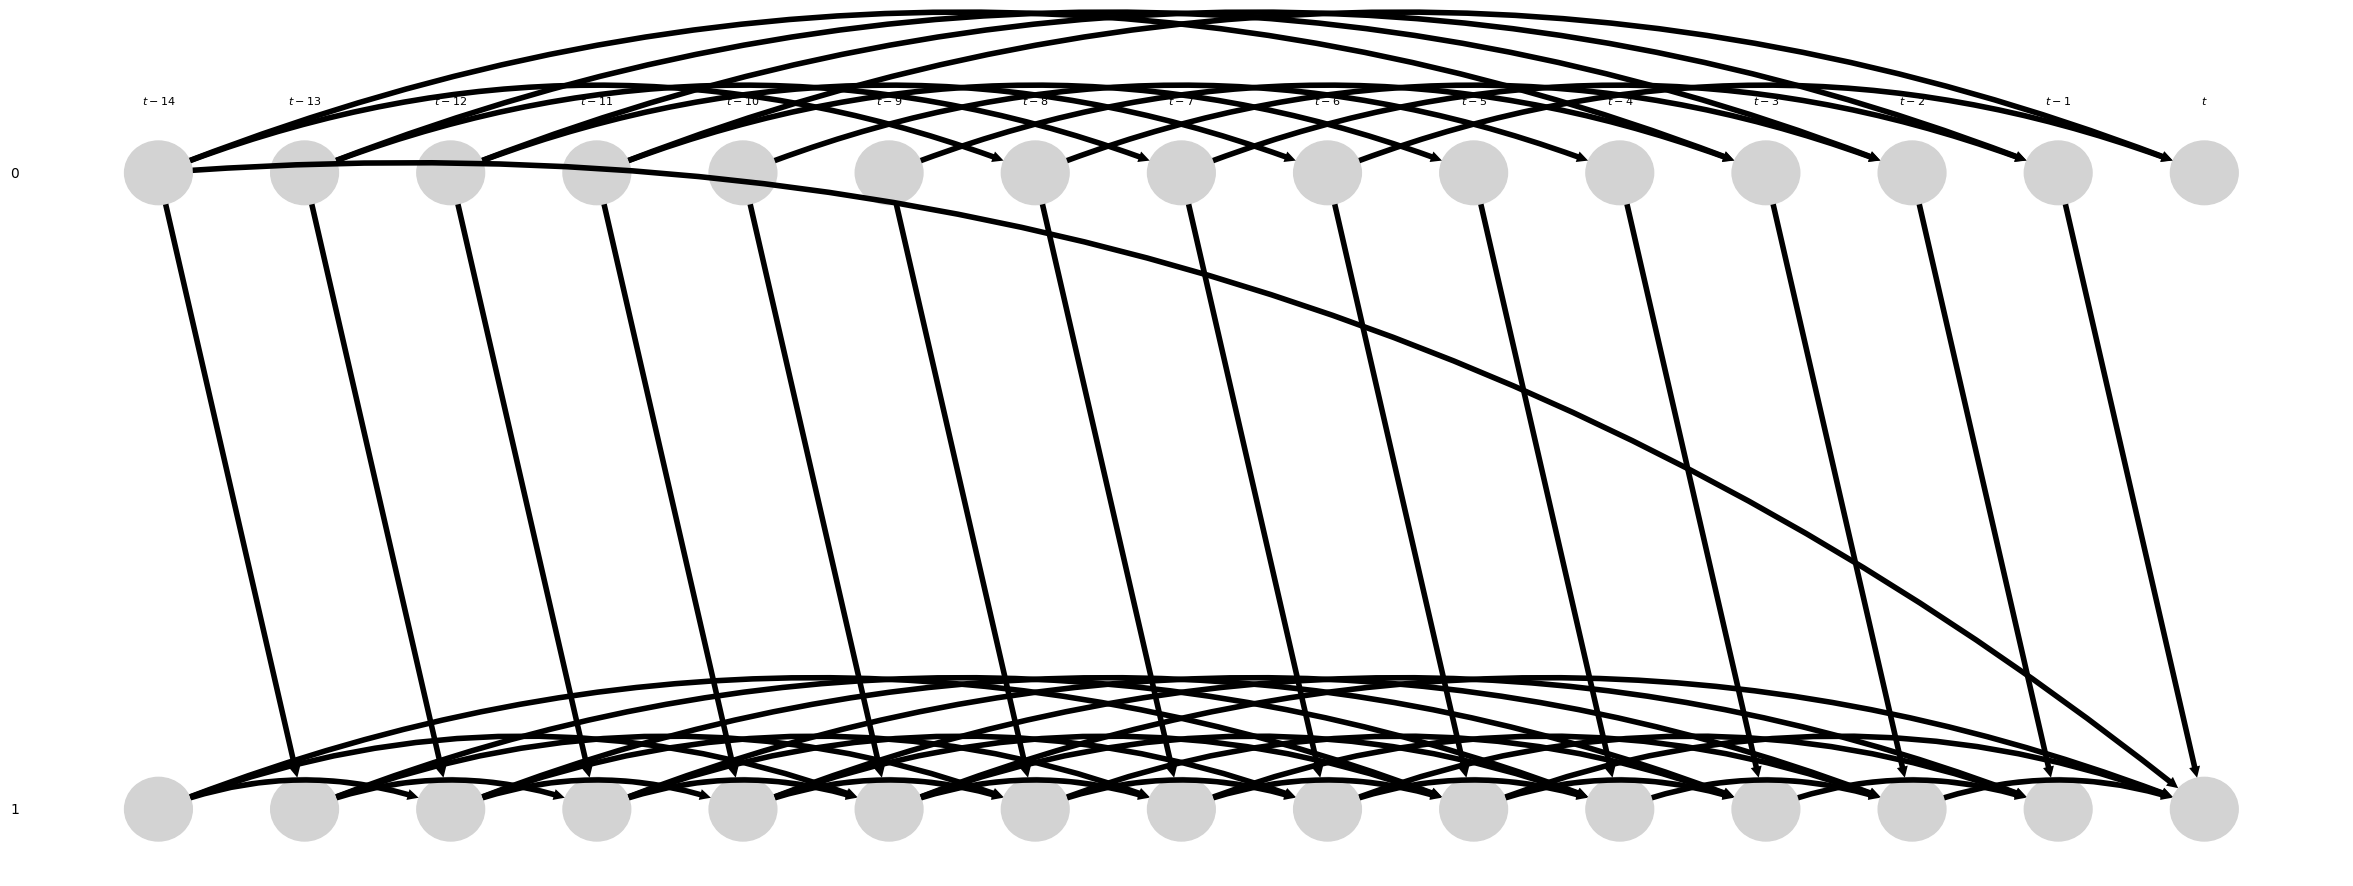

In [ ]:
# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=simplified_graph,
                         figsize = (30,10))
plt.savefig(f"{'C:/Users/Yixuan Liu/Downloads/DSO 585'}/time_series_dag_rainbox_six_siege_pruned.png")
plt.show()

In [ ]:
# Define the cause (X) and effect (Y) variables based on simplified graph
X = [(0, -1), (0, -14)]  # predictor at lag -1 and lag -14
Y = [(1, 0)]  # target at current time
hidden_variables = []

# Initialize the CausalEffects object
causal_effects = CausalEffects(
    graph=simplified_graph,
    graph_type='stationary_dag',
    X=X,
    Y=Y,
    S=None,
    hidden_variables=hidden_variables
)

In [ ]:
optimal_adjustment_set = causal_effects.get_optimal_set()

In [ ]:
optimal_adjustment_set

[(0, -22),
 (0, -25),
 (0, -19),
 (0, -16),
 (0, -10),
 (1, -15),
 (0, -7),
 (1, -18),
 (1, -12),
 (0, -27),
 (0, -21),
 (1, -20),
 (0, -18),
 (0, -12),
 (1, -17),
 (0, -9),
 (1, -14),
 (0, -6),
 (0, -23),
 (1, -22),
 (0, -20),
 (0, -5),
 (1, -16),
 (1, -10)]

In [ ]:
# Fit the causal effect model
causal_effects.fit_total_effect(
    dataframe=dataframe,
    estimator=LinearRegression(),
    adjustment_set='optimal',  # Use optimal adjustment set
    conditional_estimator=None,
    data_transform=None,
    mask_type=None
)

In [ ]:

# Define `intervention_data` with the correct shape
# intervention_data should have the same number of columns as the length of X
intervention_data = np.ones((1, len(X)))  # Set the predictor to 1

# Predict the total effect of the intervention
y1 = causal_effects.predict_total_effect(intervention_data=intervention_data)
print("Predicted effect when predictor is 1: ", y1)

# Predict the effect of an intervention (setting predictor to 0)
intervention_data_zero = np.zeros((1, len(X)))  # Set the predictor to 0
y0 = causal_effects.predict_total_effect(intervention_data=intervention_data_zero)
print("Predicted effect when predictor is 0: ", y0)
# Calculate the average treatment effect
beta = (y1 - y0)
print("Estimated causal effect = %.4f" % beta)

Predicted effect when predictor is 1:  [6.77536232]
Predicted effect when predictor is 0:  [6.77840861]
Estimated causal effect = -0.0030


In [ ]:
# Define the cause (X) and effect (Y) variables based on simplified graph
X = [(0, -1)]  # predictor at lag -1 and lag -14
Y = [(1, 0)]  # target at current time
hidden_variables = []

# Initialize the CausalEffects object
causal_effects = CausalEffects(
    graph=simplified_graph,
    graph_type='stationary_dag',
    X=X,
    Y=Y,
    S=None,
    hidden_variables=hidden_variables
)

In [ ]:
optimal_adjustment_set = causal_effects.get_optimal_set()

In [ ]:
optimal_adjustment_set

[(1, -5), (1, -9), (0, -14), (1, -2)]

In [ ]:
# Fit the causal effect model
causal_effects.fit_total_effect(
    dataframe=dataframe,
    estimator=LinearRegression(),
    adjustment_set='optimal',  # Use optimal adjustment set
    conditional_estimator=None,
    data_transform=None,
    mask_type=None
)

In [ ]:

# Define `intervention_data` with the correct shape
# intervention_data should have the same number of columns as the length of X
intervention_data = np.ones((1, len(X)))  # Set the predictor to 1

# Predict the total effect of the intervention
y1 = causal_effects.predict_total_effect(intervention_data=intervention_data)
print("Predicted effect when predictor is 1: ", y1)

# Predict the effect of an intervention (setting predictor to 0)
intervention_data_zero = np.zeros((1, len(X)))  # Set the predictor to 0
y0 = causal_effects.predict_total_effect(intervention_data=intervention_data_zero)
print("Predicted effect when predictor is 0: ", y0)
# Calculate the average treatment effect
beta = (y1 - y0)
print("Estimated causal effect = %.4f" % beta)

Predicted effect when predictor is 1:  [10.16006394]
Predicted effect when predictor is 0:  [10.14813001]
Estimated causal effect = 0.0119


In [ ]:
# Define the cause (X) and effect (Y) variables based on simplified graph
X = [(0, -14)]  # predictor at lag -1 and lag -14
Y = [(1, 0)]  # target at current time
hidden_variables = []

# Initialize the CausalEffects object
causal_effects = CausalEffects(
    graph=simplified_graph,
    graph_type='stationary_dag',
    X=X,
    Y=Y,
    S=None,
    hidden_variables=hidden_variables
)

In [ ]:
optimal_adjustment_set = causal_effects.get_optimal_set()

In [ ]:
optimal_adjustment_set

[(0, -22),
 (0, -25),
 (0, -19),
 (0, -16),
 (0, -10),
 (1, -15),
 (0, -7),
 (1, -18),
 (1, -12),
 (0, -27),
 (0, -21),
 (1, -20),
 (0, -18),
 (0, -12),
 (1, -17),
 (0, -9),
 (1, -14),
 (0, -6),
 (0, -23),
 (1, -22),
 (0, -20),
 (0, -5),
 (1, -16),
 (1, -10),
 (0, -1)]

In [ ]:
# Fit the causal effect model
causal_effects.fit_total_effect(
    dataframe=dataframe,
    estimator=LinearRegression(),
    adjustment_set='optimal',  # Use optimal adjustment set
    conditional_estimator=None,
    data_transform=None,
    mask_type=None
)

In [ ]:

# Define `intervention_data` with the correct shape
# intervention_data should have the same number of columns as the length of X
intervention_data = np.ones((1, len(X)))  # Set the predictor to 1

# Predict the total effect of the intervention
y1 = causal_effects.predict_total_effect(intervention_data=intervention_data)
print("Predicted effect when predictor is 1: ", y1)

# Predict the effect of an intervention (setting predictor to 0)
intervention_data_zero = np.zeros((1, len(X)))  # Set the predictor to 0
y0 = causal_effects.predict_total_effect(intervention_data=intervention_data_zero)
print("Predicted effect when predictor is 0: ", y0)
# Calculate the average treatment effect
beta = (y1 - y0)
print("Estimated causal effect = %.4f" % beta)

Predicted effect when predictor is 1:  [7.02339138]
Predicted effect when predictor is 0:  [7.03637692]
Estimated causal effect = -0.0130
